In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        
    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [6]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

### For some analysis in MVAPFit notebook, use another way of measuring errors

In [7]:
import numpy as np
from sklearn.svm import SVR

def degress_to_cos_sin(degrees):
    # input: 0-180
    degrees = degrees % 180
    degrees = degrees * 2
    rads = np.deg2rad(degrees)
    c, s = np.cos(rads), np.sin(rads)
    return c, s

def cos_sin_to_degrees(cos_data, sin_data):
    rads = np.arctan2(sin_data, cos_data)
    degrees = np.rad2deg(rads)
    degrees = degrees % 360
    degrees = degrees / 2
    return degrees

def convert_stim_to_y(behav_df, stim_name, lmb):
    # masking
    stims = behav_df[stim_name].to_numpy()
    mask = lmb(behav_df) & (~(np.isnan(stims)))
    stims = stims[mask]
    return mask, stims

def prepare_continuous_regressor_xs_ys(subj, time_steps, stim_name, lmb, return_behav_df=False):
    features, behav_df = load_subject_time_feature(subj, time_steps)
    mask, ys = convert_stim_to_y(behav_df, stim_name, lmb)
    features = features[mask]

    if not return_behav_df:
        return features, ys
    else:
        behav_df = behav_df[mask]
        return features, ys, behav_df

def svr_trigonometric_regression(X_train, y_train, X_test):
    cos_train, sin_train = degress_to_cos_sin(y_train)

    # Train SVR for cosine and sine components
    # fit the model
    svr_cos = SVR(kernel='rbf')
    svr_sin = SVR(kernel='rbf')

    svr_cos.fit(X_train, cos_train)
    svr_sin.fit(X_train, sin_train)

    # test the model
    cos_pred = svr_cos.predict(X_test)
    sin_pred = svr_sin.predict(X_test)
    y_pred = cos_sin_to_degrees(cos_pred, sin_pred)

    return y_pred


In [8]:
def angle_diff(x1, x2, epoch=180):
    d1 = x1 - x2
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

## Code for display results

In [9]:
import scipy.stats as scystats

def get_err_distrib_scale(errs):
    errs = errs[~np.isnan(errs)]
    _, scale = scystats.expon.fit(np.abs(errs)+1, floc=0)
    return scale

In [10]:
import statsmodels.api as sm

def display_regression(ax, l1, l2):
    x_with_const = sm.add_constant(l1)
    model = sm.OLS(l2, x_with_const).fit()
    predictions = model.get_prediction(x_with_const)
    summary_frame = predictions.summary_frame(alpha=0.05)

    # Get confidence intervals of the model
    conf_int = model.conf_int(alpha=0.05)

    # Get standard errors
    y_pred = summary_frame['mean']                 # Predicted values
    ci_lower = summary_frame['mean_ci_lower']      # Lower bound of confidence interval
    ci_upper = summary_frame['mean_ci_upper']

    # plot it
    order = np.argsort(l1)
    ax.plot(l1[order], y_pred[order], color='red', label=f'Regression Line: y={model.params[1]:.2f}x+{model.params[0]:.2f}')
    ax.fill_between(l1[order], ci_lower[order], ci_upper[order], color='gray', alpha=0.3)

    # show p value
    p_values = model.pvalues
    # print(p_values)
    return conf_int, p_values

def display_regression_with_plot(l1, l2, xlabel, ylabel):
    _, ax = plt.subplots(1, figsize=(3, 3))
    ax.plot(l1, l2, 'o')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    _, pval = display_regression(ax, l1, l2)
    return pval


In [11]:
def display_err_distrib(ax, errs, nbins=20, toflip=False, label=None, alpha=0.3):
    if toflip:
        bins = np.linspace(0, 90, nbins+1)
        errs = np.abs(errs)
        bar_width = 90 / nbins
    else:
        bins = np.linspace(-90, 90, nbins+1)
        bar_width = 180 / nbins
    err_hist, _ = np.histogram(errs, bins=bins)
    err_hist = err_hist / np.sum(err_hist)
    bin_xs = ((bins[1:] + bins[:-1]) / 2 ).astype(int)
    bars = ax.bar(bin_xs, err_hist, width=bar_width, alpha=alpha)
    ax.axhline(1/len(bin_xs), color='red', linestyle='--')
    if not toflip:
        ax.axvline(0, color='yellow', linestyle='--')

    # finally plot the line to make it clearer
    bar_color = bars[0].get_facecolor()  # Get color from bars
    ax.plot(
        bin_xs, err_hist, linestyle='-', 
        color=bar_color, alpha=1, linewidth=3, label=label) 
    ax.set_xlim([bins[0], bins[-1]])

In [12]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa')

### Code for train, test within or across subjects

In [13]:
def load_only_one_stim_data(subj, stim_id, phase):
    # load only stim1 or stim 2
    has_prev_lmb = lambda d: (~(d['prev_last_response'].isna())).to_numpy()
    one_stim_lmb = lambda d: ((d['trial_code'] == 0) & (d[f'stim_{stim_id}_to_report']) & ~(d[f'stim_{3-stim_id}_to_report'])).to_numpy()
    selected_lmb = lambda d: has_prev_lmb(d) & one_stim_lmb(d)
    target = f'stim_{stim_id}'
    stim_xs, stim_ys, stim_df = prepare_continuous_regressor_xs_ys(
        subj, phase, target, selected_lmb, return_behav_df=True)

    return stim_xs, stim_ys, stim_df

def load_relaxed_stim_data(subj, stim_id, phase):
    # as long as the stim is cued
    has_prev_lmb = lambda d: (~(d['prev_last_response'].isna())).to_numpy()
    stim_lmb = lambda d: ((d['trial_code'] == 1) | (d[f'stim_{stim_id}_to_report'])).to_numpy()
    selected_lmb = lambda d: has_prev_lmb(d) & stim_lmb(d)
    target = f'stim_{stim_id}'
    stim_xs, stim_ys, stim_df = prepare_continuous_regressor_xs_ys(
        subj, phase, target, selected_lmb, return_behav_df=True)

    return stim_xs, stim_ys, stim_df

def load_n_stims(subj, stim_types, phase):
    xs, ys, df = [], [], []
    for stim_type in stim_types:
        if stim_type == 'relaxed_1':
            stim_xs, stim_ys, stim_df = load_relaxed_stim_data(subj, 1, phase)
        elif stim_type == 'only_1':
            stim_xs, stim_ys, stim_df = load_only_one_stim_data(subj, 1, phase)
        elif stim_type == 'relaxed_2':
            stim_xs, stim_ys, stim_df = load_relaxed_stim_data(subj, 2, phase)
        elif stim_type == 'only_2':
            stim_xs, stim_ys, stim_df = load_only_one_stim_data(subj, 2, phase)
        else:
            raise ValueError(f'Unknown stim type: {stim_type}')
        xs.append(stim_xs)
        ys.append(stim_ys)
        df.append(stim_df)

    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    df = pd.concat(df, axis=0, ignore_index=True)
    return xs, ys, df

In [14]:
def within_subj_cross_phase_train_test(
        subj, phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb,
        feature_mask, kfold):
    
    # load for both s1 and s2
    xs1, ys1, df1 = load_n_stims(subj, phase1_stim_types, phase1)
    xs2, ys2, df2 = load_n_stims(subj, phase2_stim_types, phase2)

    # masking
    mask1 = phase1_lmb(df1)
    xs1, ys1, df1 = xs1[mask1], ys1[mask1], df1[mask1]
    mask2 = phase2_lmb(df2)
    xs2, ys2, df2 = xs2[mask2], ys2[mask2], df2[mask2]
    
    # truncate it a bit for now
    xs1 = xs1.T[feature_mask].T
    xs2 = xs2.T[feature_mask].T

    # cv
    all_trial_ids = df1['TRIALID'].unique()
    np.random.shuffle(all_trial_ids)
    heldout_trial_ids = np.array_split(all_trial_ids, kfold)

    subj_ys_gts = []
    subj_ys_preds = []
    subj_dfs = []
    
    for i in range(kfold):
        # train and test mask
        train_heldout_mask = df1['TRIALID'].isin(heldout_trial_ids[i])
        train_mask = ~train_heldout_mask
        train_trial_ids = df1[train_mask]['TRIALID'].unique()
        test_heldout_mask = df2['TRIALID'].isin(train_trial_ids)
        test_mask = ~test_heldout_mask
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        # test
        fold_pred = svr_trigonometric_regression(fold_train_xs, fold_train_ys, fold_test_xs)
        # collect results
        subj_ys_gts.append(fold_test_ys)
        subj_ys_preds.append(fold_pred)
        subj_dfs.append(df2[test_mask])

    subj_ys_gts = np.concatenate(subj_ys_gts, axis=0)
    subj_ys_preds = np.concatenate(subj_ys_preds, axis=0)
    subj_df = pd.concat(subj_dfs, axis=0, ignore_index=True)
    return subj_ys_gts, subj_ys_preds, subj_df

In [15]:
from tqdm import tqdm

def prepare_subj_collected(
        phase, phase_stim_types, phase_lmb, feature_mask):
    all_subj_tags = []
    all_subj_xs, all_subj_ys, all_subj_dfs = [], [], []
    print('collecting data...')
    for subj in tqdm(all_subjs):
        xs, ys, df = load_n_stims(subj, phase_stim_types, phase)
        mask = phase_lmb(df)
        xs, ys, df = xs[mask], ys[mask], df[mask]
        xs = xs.T[feature_mask].T
        # collect
        all_subj_xs.append(xs)
        all_subj_ys.append(ys)
        all_subj_dfs.append(df)
        all_subj_tags.append([subj,] * len(ys))
    all_subj_xs = np.concatenate(all_subj_xs, axis=0)
    all_subj_ys = np.concatenate(all_subj_ys, axis=0)
    all_subj_dfs = pd.concat(all_subj_dfs, axis=0, ignore_index=True)
    all_subj_tags = np.concatenate(all_subj_tags)
    return all_subj_xs, all_subj_ys, all_subj_dfs, all_subj_tags

def across_subj_cross_phase_train_test(
        phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb,
        feature_mask, kfold):
    
    # load all data for all subjects
    xs1, ys1, df1, tags1 = prepare_subj_collected(
        phase1, phase1_stim_types, phase1_lmb, feature_mask)
    xs2, ys2, df2, tags2 = prepare_subj_collected(
        phase2, phase2_stim_types, phase2_lmb, feature_mask)

    # cv
    all_subj_ids = list(set(tags1))
    np.random.shuffle(all_subj_ids)
    heldout_subj_ids = np.array_split(all_subj_ids, kfold)
    heldout_subj_ids = [set(subj_ids) for subj_ids in heldout_subj_ids]

    ys_gts = []
    ys_preds = []
    dfs = []
    subjs = []
    
    print('start train/test...')
    for i in tqdm(list(range(kfold))):
        # train and test mask
        train_heldout_mask = np.array(
            [s in heldout_subj_ids[i] for s in tags1])
        train_mask = ~train_heldout_mask
        train_subj_ids = set(tags1[train_mask])
        test_heldout_mask = np.array(
            [s in train_subj_ids for s in tags2])
        test_mask = ~test_heldout_mask
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        # test
        fold_pred = svr_trigonometric_regression(fold_train_xs, fold_train_ys, fold_test_xs)
        # collect results
        ys_gts.append(fold_test_ys)
        ys_preds.append(fold_pred)
        dfs.append(df2[test_mask])
        subjs.append(tags2[test_mask])

    ys_gts = np.concatenate(ys_gts, axis=0)
    ys_preds = np.concatenate(ys_preds, axis=0)
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    subjs = np.concatenate(subjs)

    return subjs, ys_gts, ys_preds, dfs

## Train and test within each subject

### Determine phases

In [16]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10

### Focus on ISI

#### within subjects

In [17]:
from tqdm import tqdm

default_isi_lmb = lambda d: ((d['trial_code'] == 1) | (d['stim_1_to_report'])).to_numpy()
default_feature_mask = np.arange(32)

all_isi_within_errs = {}
for subj in tqdm(all_subjs):
    subj_gts, subj_preds, _ = within_subj_cross_phase_train_test(
        subj, ISI_phase, ISI_phase, 
        ['relaxed_1',], ['relaxed_1',],
        default_isi_lmb, default_isi_lmb,
        default_feature_mask, 5)
    subj_errs = angle_diff(subj_preds, subj_gts)
    all_isi_within_errs[subj] = subj_errs

100%|██████████| 33/33 [00:02<00:00, 14.26it/s]


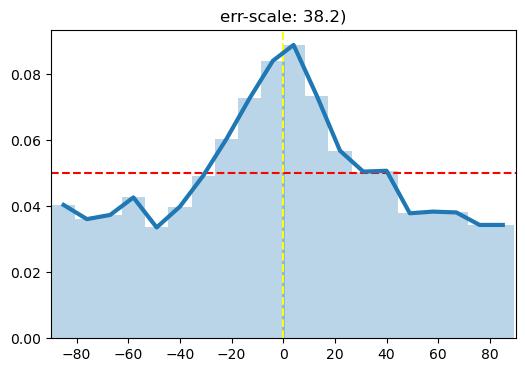

In [18]:
fig, ax = plt.subplots(1, figsize=(6, 4))
all_errs = np.concatenate(list(all_isi_within_errs.values()), axis=0)
display_err_distrib(ax, all_errs)
error_scale = get_err_distrib_scale(all_errs)
ax.set_title(f'err-scale: {error_scale:.1f})')
plot_path = os.path.join(PLOTS_FOLDER, 'within_isi_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

#### across subjects

In [19]:
subjs, gts, preds, _ = across_subj_cross_phase_train_test(
    ISI_phase, ISI_phase, 
    ['relaxed_1',], ['relaxed_1',],
    default_isi_lmb, default_isi_lmb,
    default_feature_mask, 5)

collecting data...


100%|██████████| 33/33 [00:00<00:00, 73.18it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 77.11it/s]


start train/test...


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


In [20]:
all_isi_across_errs = {}
errs = angle_diff(preds, gts)
for subj, err in zip(subjs, errs):
    all_isi_across_errs.setdefault(subj, []).append(err)

In [21]:
all_isi_across_errs = {subj: np.array(errs) for subj, errs in all_isi_across_errs.items()}

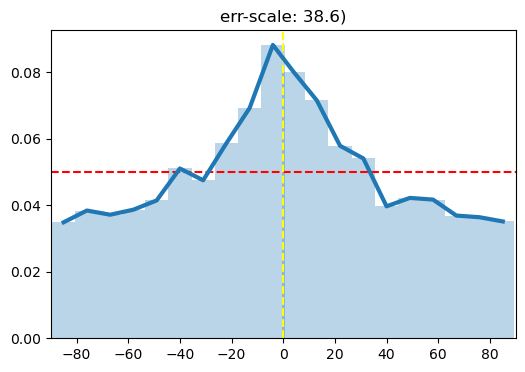

In [22]:
fig, ax = plt.subplots(1, figsize=(6, 4))
all_errs = np.concatenate(list(all_isi_across_errs.values()), axis=0)
display_err_distrib(ax, all_errs)
error_scale = get_err_distrib_scale(all_errs)
ax.set_title(f'err-scale: {error_scale:.1f})')
plot_path = os.path.join(PLOTS_FOLDER, 'across_isi_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

#### draw v.s. click?

In [23]:
default_isi_lmb = lambda d: ((d['trial_code'] == 1) | (d['stim_1_to_report'])).to_numpy()
draw_isi_lmb = lambda d: (((d['mode'] == 'draw').to_numpy())) & default_isi_lmb(d)
click_isi_lmb = lambda d: (((d['mode'] == 'click').to_numpy())) & default_isi_lmb(d)
mode_isi_lmb = {
    'draw': draw_isi_lmb,
    'click': click_isi_lmb,
}

##### within

In [24]:
all_isi_within_errs_modes = {}
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        subj_dict = {}
        for subj in tqdm(all_subjs):
            subj_gts, subj_preds, _ = within_subj_cross_phase_train_test(
                subj, ISI_phase, ISI_phase, 
                ['relaxed_1',], ['relaxed_1',],
                mode_isi_lmb[train_mode], mode_isi_lmb[test_mode],
                default_feature_mask, 5)
            subj_errs = angle_diff(subj_preds, subj_gts)
            subj_dict[subj] = subj_errs
        all_isi_within_errs_modes[(train_mode, test_mode)] = subj_dict

100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


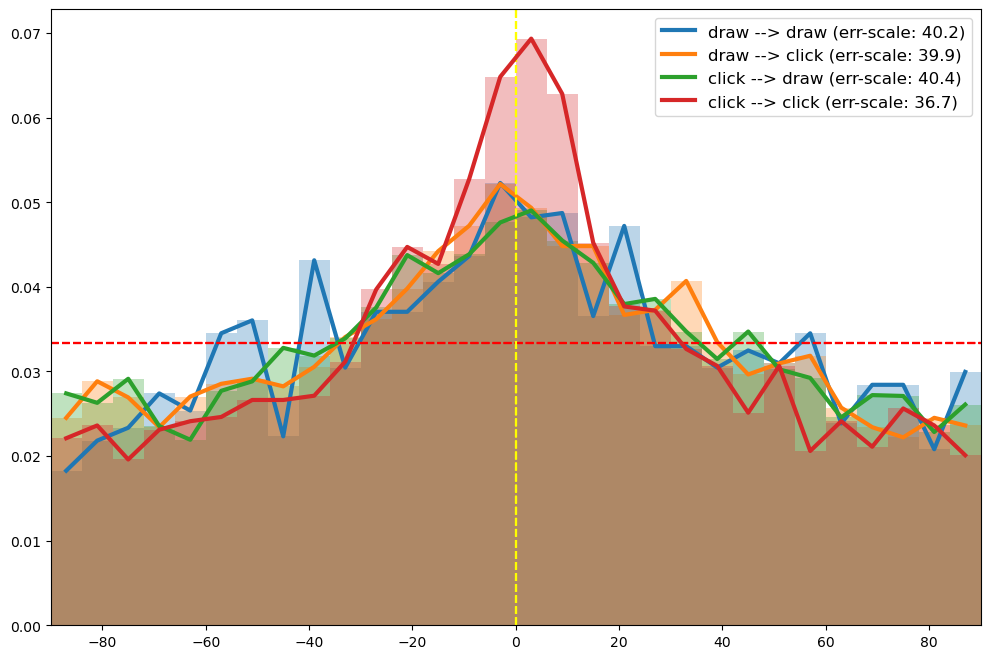

In [25]:
fig, ax = plt.subplots(1, figsize=(12, 8))
for train_id, train_mode in enumerate(['draw', 'click']):
    for test_id, test_mode in enumerate(['draw', 'click']):
        all_errs = np.concatenate(list(all_isi_within_errs_modes[(train_mode, test_mode)].values()), axis=0)
        error_scale = get_err_distrib_scale(all_errs)
        plot_label = f'{train_mode} --> {test_mode} (err-scale: {error_scale:.1f})'
        display_err_distrib(ax, all_errs, label=plot_label, nbins=30)

ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
plot_path = os.path.join(PLOTS_FOLDER, 'within_isi_modes_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

##### across

In [26]:
all_isi_across_errs_modes = {}
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        subj_dict = {}
        subjs, gts, preds, _ = across_subj_cross_phase_train_test(
            ISI_phase, ISI_phase, 
            ['relaxed_1',], ['relaxed_1',],
            mode_isi_lmb[train_mode], mode_isi_lmb[test_mode],
            default_feature_mask, 5)
        errs = angle_diff(preds, gts)
        for subj, err in zip(subjs, errs):  
            subj_dict.setdefault(subj, []).append(err)
        all_isi_across_errs_modes[(train_mode, test_mode)] = subj_dict

collecting data...


100%|██████████| 33/33 [00:00<00:00, 67.13it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 65.69it/s]


start train/test...


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 80.46it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 85.45it/s]


start train/test...


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 86.35it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 85.16it/s]


start train/test...


100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 88.24it/s]


collecting data...


100%|██████████| 33/33 [00:00<00:00, 82.76it/s]


start train/test...


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


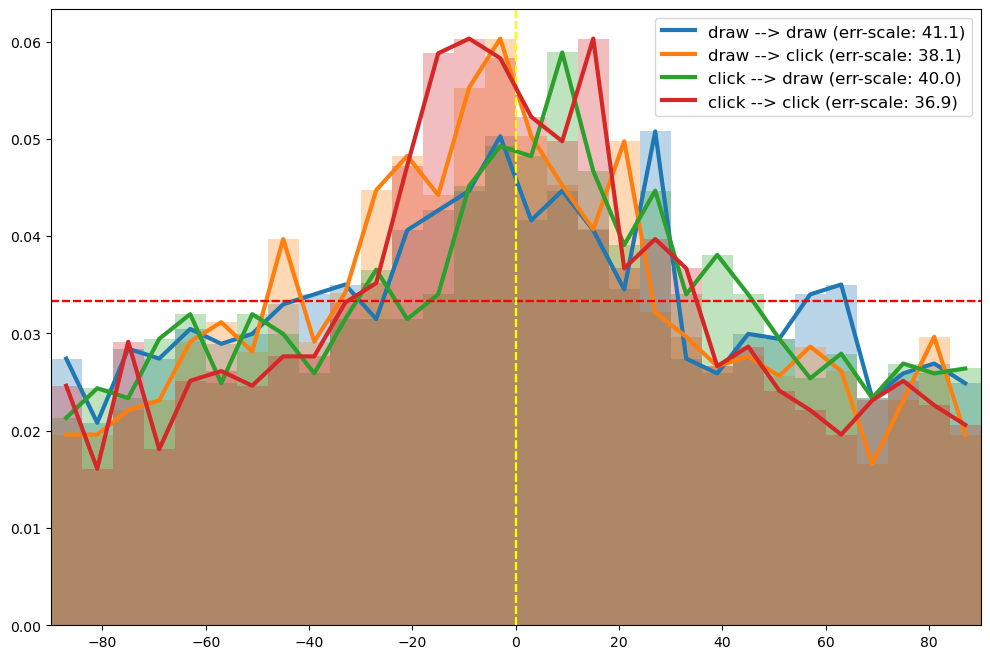

In [27]:
fig, ax = plt.subplots(1, figsize=(12, 8))
for train_id, train_mode in enumerate(['draw', 'click']):
    for test_id, test_mode in enumerate(['draw', 'click']):
        all_errs = np.concatenate(
            list(all_isi_across_errs_modes[(train_mode, test_mode)].values()), axis=0)
        error_scale = get_err_distrib_scale(all_errs)
        plot_label = f'{train_mode} --> {test_mode} (err-scale: {error_scale:.1f})'
        display_err_distrib(ax, all_errs, label=plot_label, nbins=30)

ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
plot_path = os.path.join(PLOTS_FOLDER, 'across_isi_modes_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Now apply the same analysis but to delay data

In [28]:
# use leave one out
draw_lmb = lambda d: (((d['mode'] == 'draw').to_numpy()))
click_lmb = lambda d: (((d['mode'] == 'click').to_numpy()))
mode_lmbs = {
    'draw': draw_lmb,
    'click': click_lmb,
}

N_subjs = len(all_subjs)
all_delay_across_errs_modes = {}
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        subj_dict = {}
        subjs, gts, preds, _ = across_subj_cross_phase_train_test(
            delay_phase, delay_phase, 
            ['only_1', 'only_2'], ['only_1', 'only_2'],
            mode_lmbs[train_mode], mode_lmbs[test_mode],
            default_feature_mask, kfold=N_subjs)
        errs = angle_diff(preds, gts)
        for subj, err in zip(subjs, errs):  
            subj_dict.setdefault(subj, []).append(err)
        all_delay_across_errs_modes[(train_mode, test_mode)] = subj_dict

collecting data...


100%|██████████| 33/33 [00:12<00:00,  2.64it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  7.90it/s]


start train/test...


100%|██████████| 33/33 [00:01<00:00, 22.65it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  7.13it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  6.71it/s]


start train/test...


100%|██████████| 33/33 [00:01<00:00, 16.92it/s]


collecting data...


100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  6.80it/s]


start train/test...


100%|██████████| 33/33 [00:01<00:00, 18.55it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  7.17it/s]


collecting data...


100%|██████████| 33/33 [00:04<00:00,  8.24it/s]


start train/test...


100%|██████████| 33/33 [00:01<00:00, 19.12it/s]


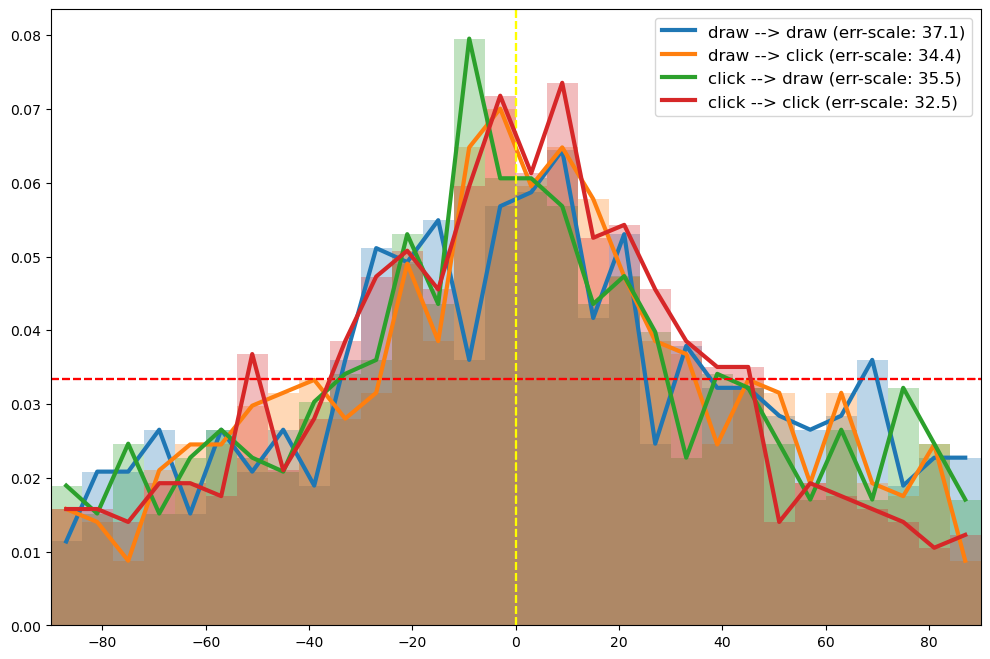

In [29]:
fig, ax = plt.subplots(1, figsize=(12, 8))
for train_id, train_mode in enumerate(['draw', 'click']):
    for test_id, test_mode in enumerate(['draw', 'click']):
        all_errs = np.concatenate(
            list(all_delay_across_errs_modes[(train_mode, test_mode)].values()), axis=0)
        error_scale = get_err_distrib_scale(all_errs)
        plot_label = f'{train_mode} --> {test_mode} (err-scale: {error_scale:.1f})'
        display_err_distrib(ax, all_errs, label=plot_label, nbins=30)

ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
plot_path = os.path.join(PLOTS_FOLDER, 'across_delay_modes_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Finally, compare between and across subject accuracy

In [30]:
all_isi_within_err_scales = np.array([
    get_err_distrib_scale(all_isi_within_errs[subj]) for subj in all_subjs
])
all_isi_across_err_scales = np.array([
    get_err_distrib_scale(all_isi_across_errs[subj]) for subj in all_subjs
])


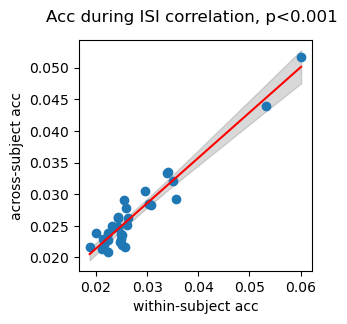

In [32]:
pval = display_regression_with_plot(
    1 / all_isi_within_err_scales, 
    1 / all_isi_across_err_scales, 
    'within-subject acc', 'across-subject acc')
pval_str = f'p={pval[1]:.3f}' if pval[1] > 0.001 else f'p<0.001'
plt.suptitle(f'Acc during ISI correlation, {pval_str}')
plot_path = os.path.join(
    PLOTS_FOLDER, 'isi_err_scale_regression.png')
plt.savefig(plot_path, bbox_inches='tight')

### Next, we examine the long dalay

#### Firstly, use mem-load = 1 data

##### Combined all, trained on delay, tested on delay
- cross subject only (otherwise not enough data)

In [33]:
default_lmb = lambda d: np.ones(len(d)).astype(bool)

delay_subjs, delay_gts, delay_preds, delay_dfs = across_subj_cross_phase_train_test(
    delay_phase, delay_phase, 
    ['only_1', 'only_2'], ['only_1', 'only_2'],
    default_lmb, default_lmb,
    default_feature_mask, 5)

collecting data...


100%|██████████| 33/33 [00:05<00:00,  6.08it/s]


collecting data...


100%|██████████| 33/33 [00:05<00:00,  6.24it/s]


start train/test...


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


In [34]:
all_delay_across_errs = {}
all_delay_across_sds = {}
delay_errs = angle_diff(delay_preds, delay_gts)
delay_sds = angle_diff(delay_dfs['prev_last_response'].to_numpy(), delay_gts)
for i in range(len(delay_subjs)):
    subj = delay_subjs[i]
    err = delay_errs[i]
    sd = delay_sds[i]
    all_delay_across_errs.setdefault(subj, []).append(err)
    all_delay_across_sds.setdefault(subj, []).append(sd)

In [35]:
all_delay_across_errs = {subj: np.array(errs) for subj, errs in all_delay_across_errs.items()}
all_delay_across_sds = {subj: np.array(sds) for subj, sds in all_delay_across_sds.items()}

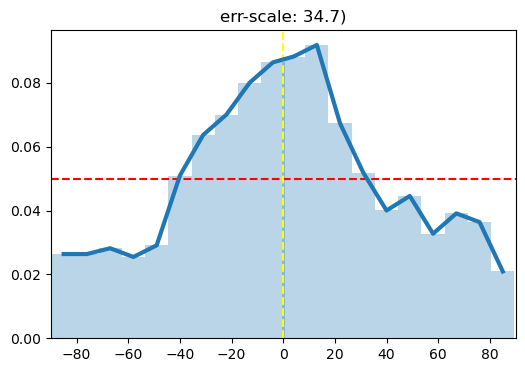

In [36]:
# plot the err distribution
fig, ax = plt.subplots(1, figsize=(6, 4))
all_errs = np.concatenate(list(all_delay_across_errs.values()), axis=0)
display_err_distrib(ax, all_errs)
error_scale = get_err_distrib_scale(all_errs)
ax.set_title(f'err-scale: {error_scale:.1f})')
plot_path = os.path.join(PLOTS_FOLDER, 'across_delay_err_distrib.png')
plt.savefig(plot_path, bbox_inches='tight')

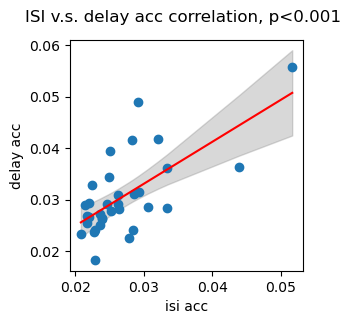

In [37]:
### correlate isi and delay acc
all_delay_across_err_scales = np.array([
    get_err_distrib_scale(all_delay_across_errs[subj]) for subj in all_subjs
])

pval = display_regression_with_plot(
    1 / all_isi_across_err_scales, 
    1 / all_delay_across_err_scales, 
    'isi acc', 'delay acc')
pval_str = f'p={pval[1]:.3f}' if pval[1] > 0.001 else f'p<0.001'
plt.suptitle(f'ISI v.s. delay acc correlation, {pval_str}')
plot_path = os.path.join(
    PLOTS_FOLDER, 'isi_delay_acc_regression.png')
plt.savefig(plot_path, bbox_inches='tight')

#### now check serial dependence?

In [103]:
from scipy import stats

def compute_serial_bias_in_fitting_result(
        errs, diffs, 
        err_threshold,
        n_diff_bins):
    # get distribution of errors (in general)
    err_scale = get_err_distrib_scale(errs)

    # get serial biases
    err_threshold = 20
    valid_mask = np.abs(errs) <= err_threshold
    errs_valid, diffs_valid = errs[valid_mask], diffs[valid_mask]
    
    ## flip it
    flip_mask = diffs_valid < 0
    errs_valid[flip_mask] = -errs_valid[flip_mask]
    diffs_valid[flip_mask] = -diffs_valid[flip_mask]
    
    # group by diff
    diff_edges = np.linspace(0, 90, n_diff_bins+1)
    bin_xs = (diff_edges[:-1] + diff_edges[1:]) / 2
    group_ids = np.digitize(diffs_valid, diff_edges)

    # get the stats
    err_grouped = [[] for _ in range(n_diff_bins)]

    for y, bin_idx in zip(errs_valid, group_ids):
        if bin_idx >= 1 and bin_idx <= n_diff_bins:
            err_grouped[bin_idx-1].append(y)
    
    t_stats = []
    p_values = []
    mean_errs = []
    for i in range(n_diff_bins):
        tstat, pval, mean_err = np.nan, np.nan, np.nan
        if len(err_grouped[i]) >= 2:
            ttest_res = stats.ttest_1samp(err_grouped[i], 0)
            tstat = ttest_res.statistic
            pval = ttest_res.pvalue
            mean_err = np.mean(err_grouped[i])
        t_stats.append(tstat)
        p_values.append(pval)
        mean_errs.append(mean_err)
    
    return bin_xs, t_stats, p_values, mean_errs


def display_serial_bias(ax, errs, diffs, err_thresh, n_diff_bins):
    sdx, _, sdp, sdy = compute_serial_bias_in_fitting_result(
        errs, diffs, err_thresh, n_diff_bins)
    ax.plot(sdx, sdy, 'o-')
    ax.set_ylabel('error')
    ax.set_xlabel('diff (degrees)')
    ax.axhline(0, color='y', linestyle='--')
    ax.set_ylim(-5, 5)
    ax.set_xlim(0, 90)

    for i in range(len(sdx)):
        p = sdp[i]
        if p < 0.05:
            ax.text(
                sdx[i], sdy[i]+0.05, '*', color='red')

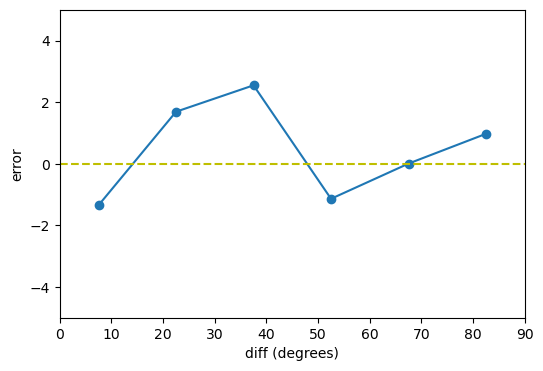

In [105]:
fig, ax = plt.subplots(1, figsize=(6, 4))
display_serial_bias(
    ax, delay_errs, delay_sds, 30, 6)
plot_path = os.path.join(
    PLOTS_FOLDER, 'delay_serial_bias.png')
plt.savefig(plot_path, bbox_inches='tight')

### Will it make more sense if we split subjects into high-low quality group?

In [28]:
eye_median = np.median(l1)
behav_median = np.median(l2)

cat1 = l1 > eye_median
cat2 = l2 > behav_median
table = pd.crosstab(cat1, cat2, rownames=['behav'], colnames=['gaze'])

# Rename index and columns for clarity
table.index = ["low perf", "high perf"]
table.columns = ["low acc", "high acc"]
table


,low acc,high acc
low perf,10,7
high perf,7,9


### Similar Analysis, but using cross-subject accuracy

In [29]:
from sklearn.preprocessing import StandardScaler

subject_features = {}
subject_cts_targets = {}
n_cats = None

delay_1_epoch = np.arange(start=2500//50, stop=3000//50).astype(int)
delay_2_epoch = np.arange(start=4250//50, stop=8750//50).astype(int)

for subj in all_subjs:
    subj_xs, subj_cts_ys = prepare_continuous_regressor_xs_ys(
        subj, delay_1_epoch, 'stim_1', delay_1_lmb)
    subject_features[subj] = subj_xs
    subject_cts_targets[subj] = subj_cts_ys

all_xs = np.concatenate(
    [subject_features[subj] for subj in all_subjs], axis=0)
all_ys = np.concatenate(
    [subject_cts_targets[subj] for subj in all_subjs], axis=0)
all_name_list = [[s for _ in range(len(subject_cts_targets[s]))] for s in all_subjs]
all_name_list = np.concatenate(all_name_list, axis=0)

scaler = StandardScaler()
all_xs = scaler.fit_transform(all_xs)


In [30]:
from sklearn.model_selection import GroupKFold

folds = len(all_subjs)
group_kfold = GroupKFold(n_splits=folds)

feature_mask = np.arange(0, 32)

eyetrack_holdout_errs = {}
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(all_xs, all_ys, groups=all_name_list)):
    subj = np.unique(all_name_list[test_idx])[0]
    print(f"Fold {fold + 1}, {subj} held out")
    
    # Split data
    X_train, X_test = all_xs[train_idx], all_xs[test_idx]
    y_train, y_test = all_ys[train_idx], all_ys[test_idx]

    # truncate it a bit for now
    X_train = X_train.T[feature_mask].T
    X_test = X_test.T[feature_mask].T

    # print(X_train.shape, X_test.shape, y_train.shape)
    
    # fitting
    subj_pred = svr_trigonometric_regression(X_train, y_train, X_test)
    subj_errs = angle_diff(subj_pred, y_test)
    eyetrack_holdout_errs[subj] = subj_errs


Fold 1, 915 held out
Fold 2, 940 held out
Fold 3, 931 held out
Fold 4, 910 held out
Fold 5, 942 held out
Fold 6, 918 held out
Fold 7, 932 held out
Fold 8, 937 held out
Fold 9, 938 held out
Fold 10, 920 held out
Fold 11, 949 held out
Fold 12, 943 held out
Fold 13, 916 held out
Fold 14, 913 held out
Fold 15, 908 held out
Fold 16, 933 held out
Fold 17, 945 held out
Fold 18, 909 held out
Fold 19, 927 held out
Fold 20, 914 held out
Fold 21, 922 held out
Fold 22, 930 held out
Fold 23, 948 held out
Fold 24, 935 held out
Fold 25, 947 held out
Fold 26, 917 held out
Fold 27, 946 held out
Fold 28, 921 held out
Fold 29, 912 held out
Fold 30, 929 held out
Fold 31, 939 held out
Fold 32, 944 held out
Fold 33, 941 held out


In [31]:
heldout_eye_err_scale = {
    subj: get_err_distrib_scale(errs) for subj, errs in eyetrack_holdout_errs.items()}

33


(array([[ 0.01109171,  0.08639565],
        [-0.59638469,  2.13553248]]),
 array([0.01285269, 0.25932361]))

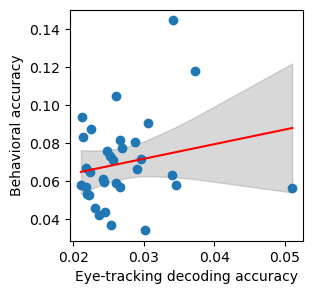

In [32]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([heldout_eye_err_scale[subj] for subj in all_subjs])
l2 = np.array([behav_err_scale[subj] for subj in all_subjs])

mask = (l2 < 30) # bad behavior performance
l1 = 1 / l1[mask]
l2 = 1 / l2[mask]

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('Eye-tracking decoding accuracy')
ax.set_ylabel('Behavioral accuracy')
display_regression(ax, l1, l2)

#### Compare within and across subjects?

33


(array([[-0.00117104,  0.00815171],
        [ 0.59013529,  0.87453649]]),
 array([1.36864965e-01, 9.78704425e-12]))

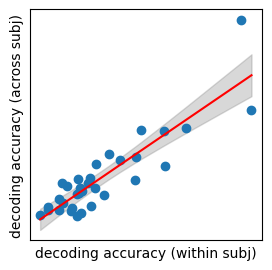

In [33]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l2 = np.array([heldout_eye_err_scale[subj] for subj in all_subjs])

l1 = 1 / l1
l2 = 1 / l2

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('decoding accuracy (within subj)')
ax.set_ylabel('decoding accuracy (across subj)')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

Text(0.5, 1.0, 'Across-subject decoding error')

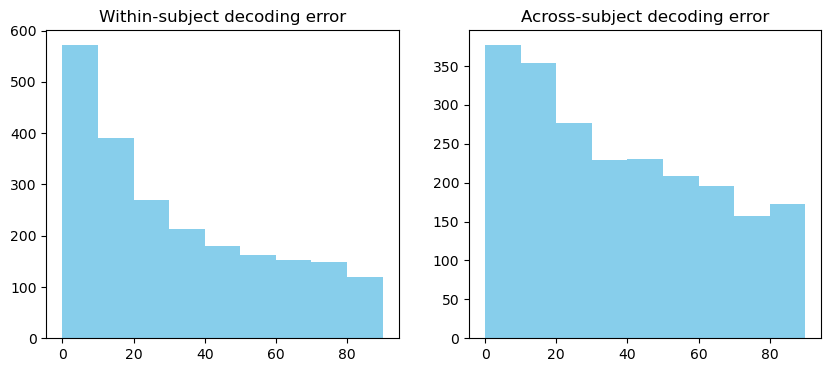

In [34]:
# plot error distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(np.concatenate(list(eyetrack_errs.values())), bins=np.linspace(0, 90, 10), color='skyblue')
axs[0].set_title('Within-subject decoding error')
axs[1].hist(np.concatenate(list(eyetrack_holdout_errs.values())), bins=np.linspace(0, 90, 10), color='skyblue')
axs[1].set_title('Across-subject decoding error')

## Progressive MVPA during the long delay

In [35]:
def load_one_stim_data(subj, phase):
    # load for both s1 and s2
    has_prev_lmb = lambda d: (~(d['prev_last_response'].isna())).to_numpy()
    xs, ys, df = [], [], []
    for stim_id in [1, 2]:
        one_stim_lmb = lambda d: ((d['trial_code'] == 0) & (d[f'stim_{stim_id}_to_report']) & ~(d[f'stim_{3-stim_id}_to_report'])).to_numpy()
        selected_lmb = lambda d: has_prev_lmb(d) & one_stim_lmb(d)
        target = f'stim_{stim_id}'
        stim_xs, stim_ys, stim_df = prepare_continuous_regressor_xs_ys(
            subj, phase, target, selected_lmb, return_behav_df=True)
        
        xs.append(stim_xs)
        ys.append(stim_ys)
        df.append(stim_df)

    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    df = pd.concat(df, axis=0, ignore_index=True)

    return xs, ys, df

def within_subj_cv_train_test(subj, phase, feature_mask, kfold):
    # load for both s1 and s2
    xs, ys, df = load_one_stim_data(subj, phase)
    
    # truncate it a bit for now
    xs = xs.T[feature_mask].T

    # cv
    N_data = len(ys)
    indices = np.arange(N_data)
    np.random.shuffle(indices)  # Shuffle to randomize assignment
    test_indices = np.array_split(indices, kfold)  # Split into n nearly equal parts
    subj_preds = np.zeros(N_data)
    
    for i in range(kfold):
        # train and test mask
        train_mask = np.full(N_data, True)
        train_mask[test_indices[i]] = False
        test_mask = np.full(N_data, False)
        test_mask[test_indices[i]] = True
        # fetch data
        fold_train_xs, fold_test_xs = xs[train_mask], xs[test_mask]
        fold_train_ys, fold_test_ys = ys[train_mask], ys[test_mask]
        # test
        fold_pred = svr_trigonometric_regression(fold_train_xs, fold_train_ys, fold_test_xs)
        subj_preds[test_mask] = fold_pred

    return ys, subj_preds, df

In [36]:
def get_all_long_delay_epochs(duration):
    all_long_delay_timepoints = np.arange(start=4500, stop=9000, step=duration)
    all_long_delay_epochs = []
    for epoch_start, epoch_end in zip(all_long_delay_timepoints[:-1], all_long_delay_timepoints[1:]):
        all_long_delay_epochs.append(
            np.arange(start=epoch_start//50, stop=epoch_end//50).astype(int))
    return all_long_delay_epochs

### Baseline: check the bias within each 

In [37]:
from scipy import stats

def compute_serial_bias_in_fitting_result(preds, gts, prs):
    # get distribution of errors (in general)
    errs = angle_diff(preds, gts)
    err_scale = get_err_distrib_scale(errs)

    # get serial biases
    diffs = angle_diff(prs, gts)
    err_threshold = 20
    err_bins=12
    valid_mask = np.abs(errs) <= err_threshold
    errs_valid, diffs_valid = errs[valid_mask], diffs[valid_mask]
    
    ## flip it
    flip_mask = diffs_valid < 0
    errs_valid[flip_mask] = -errs_valid[flip_mask]
    diffs_valid[flip_mask] = -diffs_valid[flip_mask]
    
    # histogram
    n_diff_bins = 6
    diff_edges = np.linspace(0, 90, n_diff_bins+1)
    err_edges = np.linspace(-err_threshold, err_threshold, err_bins+1)
    H, _, _ = np.histogram2d(diffs_valid, errs_valid, bins=(diff_edges, err_edges))
    err_bins = (err_edges[:-1] + err_edges[1:]) / 2

    # return the stats
    t_stats, p_values, mean_errs = [], [], []
    for i in range(n_diff_bins):
        diff_range = diff_edges[i:i+2]
        mask = (diffs_valid >= diff_range[0]) & (diffs_valid < diff_range[1])
        err_masked = errs_valid[mask]
        ttest_res = stats.ttest_1samp(err_masked, 0)
        t_stats.append(ttest_res.statistic)
        p_values.append(ttest_res.pvalue)
        # h_normalized = H[i] / np.sum(H[i])
        # mean_err = np.mean(h_normalized *err_bins)
        mean_err = np.mean(err_masked)
        mean_errs.append(mean_err)
    
    return diff_edges, t_stats, p_values, mean_errs, err_scale


In [38]:
from tqdm import tqdm

def within_epoch_test(epoch):
    # collect results
    all_preds, all_gts, all_prs = [], [], []
    for subj in tqdm(all_subjs):
        ys, subj_preds, df = within_subj_cv_train_test(subj, epoch, feature_mask, kfold=5)
        all_preds.append(subj_preds)
        all_gts.append(ys)
        prs = df['prev_last_response'].to_numpy()
        all_prs.append(prs)

    all_preds = np.concatenate(all_preds, axis=0)
    all_gts = np.concatenate(all_gts, axis=0)
    all_prs = np.concatenate(all_prs, axis=0)

    return all_preds, all_gts, all_prs

In [39]:
all_long_delay_epochs = get_all_long_delay_epochs(800)
within_epoch_results = []
diff_edges = None
for epoch in all_long_delay_epochs:
    all_preds, all_gts, all_prs = within_epoch_test(epoch)
    diff_edges, tstats, p_values, mean_errs, err_scale = compute_serial_bias_in_fitting_result(all_preds, all_gts, all_prs)
    epoch_result = {
        'epoch_start': epoch[0],
        'epoch_end': epoch[-1],
        'stats': tstats,
        'p_values': p_values,
        'mean_errs': mean_errs,
        'err_scale': err_scale,
    }
    within_epoch_results.append(epoch_result)

100%|██████████| 33/33 [00:01<00:00, 20.23it/s]


Text(0.5, 1.0, 'Decoding quality')

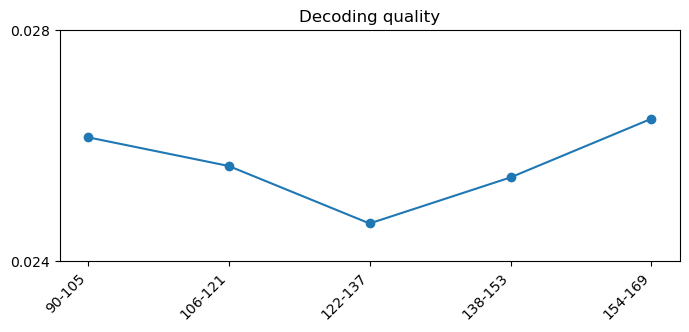

In [40]:
# check the 'quality' at different phases
fig, ax = plt.subplots(1, figsize=(8, 3))
quality = [1 / result['err_scale'] for result in within_epoch_results]
time_point_labels = [f'{result["epoch_start"]}-{result["epoch_end"]}' for result in within_epoch_results]
ax.plot(np.arange(len(quality)), quality, linestyle='-', marker='o')
_ = ax.set_xticks(np.arange(len(quality)))
_ = ax.set_xticklabels(time_point_labels, rotation=45, ha='right')
_ = ax.set_yticks([0.024, 0.028])
ax.set_title('Decoding quality')

In [41]:
stats_tables = np.zeros((len(within_epoch_results), len(diff_edges)-1))
err_tables = np.zeros((len(within_epoch_results), len(diff_edges)-1))
pval_tables = np.zeros((len(within_epoch_results), len(diff_edges)-1))
for i, epoch_result in enumerate(within_epoch_results):
    err_tables[i] = epoch_result['mean_errs']
    pval_tables[i] = epoch_result['p_values']
    stats_tables[i] = epoch_result['stats']

In [42]:
# Set up plot parameters

def plot_within_cv_results(stat_table, pval_table, diff_edges, epochs):
    N, M = stat_table.shape

    time_points = [f'{epoch[0]}-{epoch[-1]}' for epoch in epochs]
    col_labels = [f'sd diff {diff_edges[j]:.0f}-{diff_edges[j+1]:.0f}' for j in range(M)]
    colors = plt.cm.Purples_r(np.linspace(0, 1, M+2))  # Use a distinct colormap

    x = np.arange(N)  # X positions for groups
    plot_width = 1

    # Create bar plot
    fig, ax = plt.subplots(figsize=(20, 6))
    bars = []

    for j in range(N):  # Iterate over rows
        ys = stat_table[j]
        xs = x[j] * plot_width + np.arange(M) * plot_width * 0.8 / M
        bar = ax.plot(xs, ys, linestyle='-', marker='o')
        # ax.bar(x + j * bar_width - (M-1) * bar_width / 2, stat_table[:, j], 
        #     width=bar_width, color=colors[j], label=col_labels[j])
        bars.append(bar)

    # Mark significance
    for i in range(N):  # Iterate over rows (groups)
        xs = x[i] * plot_width + np.arange(M) * plot_width * 0.8 / M
        for j in range(M):  # Iterate over columns (conditions)
            if pval_table[i, j] < 0.05:  # Significance threshold
                ax.text(xs[j], 
                        stat_table[i, j] + 0.5, '*', ha='center', fontsize=12, color='red')

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(time_points, rotation=45)
    ax.set_xlabel('test epochs')
    ax.set_ylim([-4, 4])
    ax.axhline(0, linestyle='--', color='gold')
    ax.legend()


/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


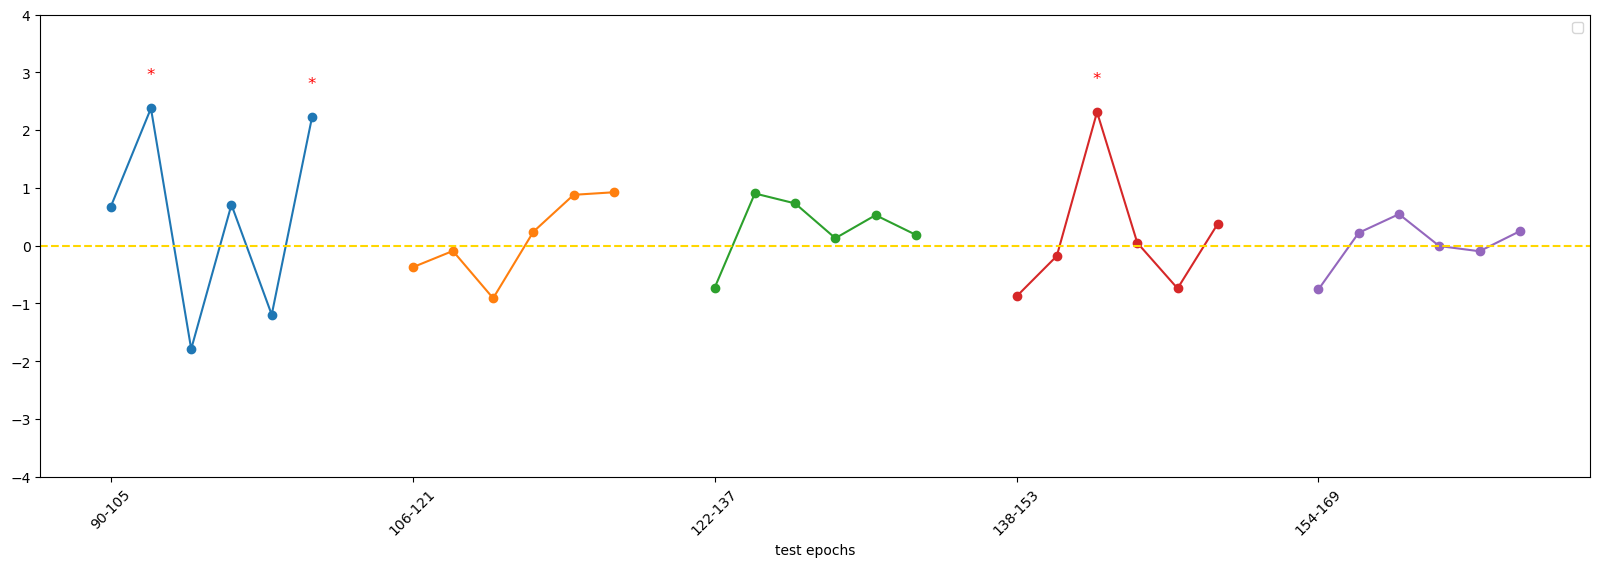

In [43]:
plot_within_cv_results(stats_tables, pval_tables, diff_edges, all_long_delay_epochs)

## Now do progressive training and testing

In [44]:
def within_subj_cross_phase_train_test(subj, phase1, phase2, feature_mask, kfold):
    # load for both s1 and s2
    xs1, ys1, df = load_one_stim_data(subj, phase1)
    xs2, ys2, _ = load_one_stim_data(subj, phase2)
    
    # truncate it a bit for now
    xs1 = xs1.T[feature_mask].T
    xs2 = xs2.T[feature_mask].T

    # cv
    N_data = len(ys1)
    indices = np.arange(N_data)
    np.random.shuffle(indices)  # Shuffle to randomize assignment
    test_indices = np.array_split(indices, kfold)  # Split into n nearly equal parts
    subj_preds = np.zeros(N_data)
    
    for i in range(kfold):
        # train and test mask
        train_mask = np.full(N_data, True)
        train_mask[test_indices[i]] = False
        test_mask = np.full(N_data, False)
        test_mask[test_indices[i]] = True
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        # test
        fold_pred = svr_trigonometric_regression(fold_train_xs, fold_train_ys, fold_test_xs)
        subj_preds[test_mask] = fold_pred

    return ys2, subj_preds, df

In [45]:
def across_epoch_test(epoch1, epoch2):
    # collect results
    all_preds, all_gts, all_prs = [], [], []
    for subj in tqdm(all_subjs):
        ys, subj_preds, df = within_subj_cross_phase_train_test(subj, epoch1, epoch2, feature_mask, kfold=5)
        all_preds.append(subj_preds)
        all_gts.append(ys)
        prs = df['prev_last_response'].to_numpy()
        all_prs.append(prs)

    all_preds = np.concatenate(all_preds, axis=0)
    all_gts = np.concatenate(all_gts, axis=0)
    all_prs = np.concatenate(all_prs, axis=0)

    return all_preds, all_gts, all_prs

In [46]:
cross_epoch_results = []
diff_edges = None
for i in range(len(all_long_delay_epochs)-1):
    epoch1, epoch2 = all_long_delay_epochs[i], all_long_delay_epochs[i+1]
    all_preds, all_gts, all_prs = across_epoch_test(epoch1, epoch2)
    diff_edges, tstats, p_values, mean_errs, err_scale = compute_serial_bias_in_fitting_result(all_preds, all_gts, all_prs)
    epoch_result = {
        'epoch_train_start': epoch1[0],
        'epoch_train_end': epoch1[-1],
        'epoch_start': epoch2[0],
        'epoch_end': epoch2[-1],
        'stats': tstats,
        'p_values': p_values,
        'mean_errs': mean_errs,
        'err_scale': err_scale,
    }
    cross_epoch_results.append(epoch_result)

100%|██████████| 33/33 [00:02<00:00, 11.36it/s]


Text(0.5, 1.0, 'Decoding quality')

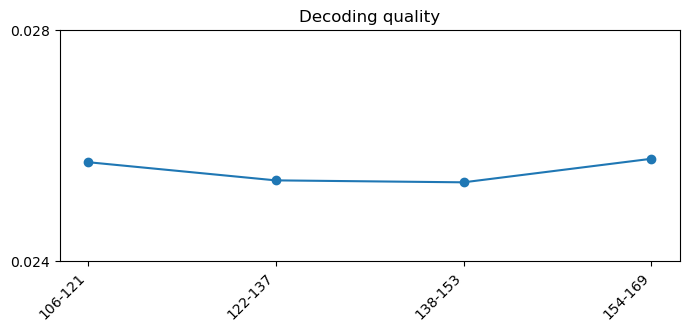

In [47]:
# check the 'quality' at different phases
fig, ax = plt.subplots(1, figsize=(8, 3))
quality = [1 / result['err_scale'] for result in cross_epoch_results]
time_point_labels = [f'{result["epoch_start"]}-{result["epoch_end"]}' for result in cross_epoch_results]
ax.plot(np.arange(len(quality)), quality, linestyle='-', marker='o')
_ = ax.set_xticks(np.arange(len(quality)))
_ = ax.set_xticklabels(time_point_labels, rotation=45, ha='right')
_ = ax.set_yticks([0.024, 0.028])
ax.set_title('Decoding quality')

In [48]:
stats_tables = np.zeros((len(cross_epoch_results), len(diff_edges)-1))
err_tables = np.zeros((len(cross_epoch_results), len(diff_edges)-1))
pval_tables = np.zeros((len(cross_epoch_results), len(diff_edges)-1))
for i, epoch_result in enumerate(cross_epoch_results):
    err_tables[i] = epoch_result['mean_errs']
    pval_tables[i] = epoch_result['p_values']
    stats_tables[i] = epoch_result['stats']

/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


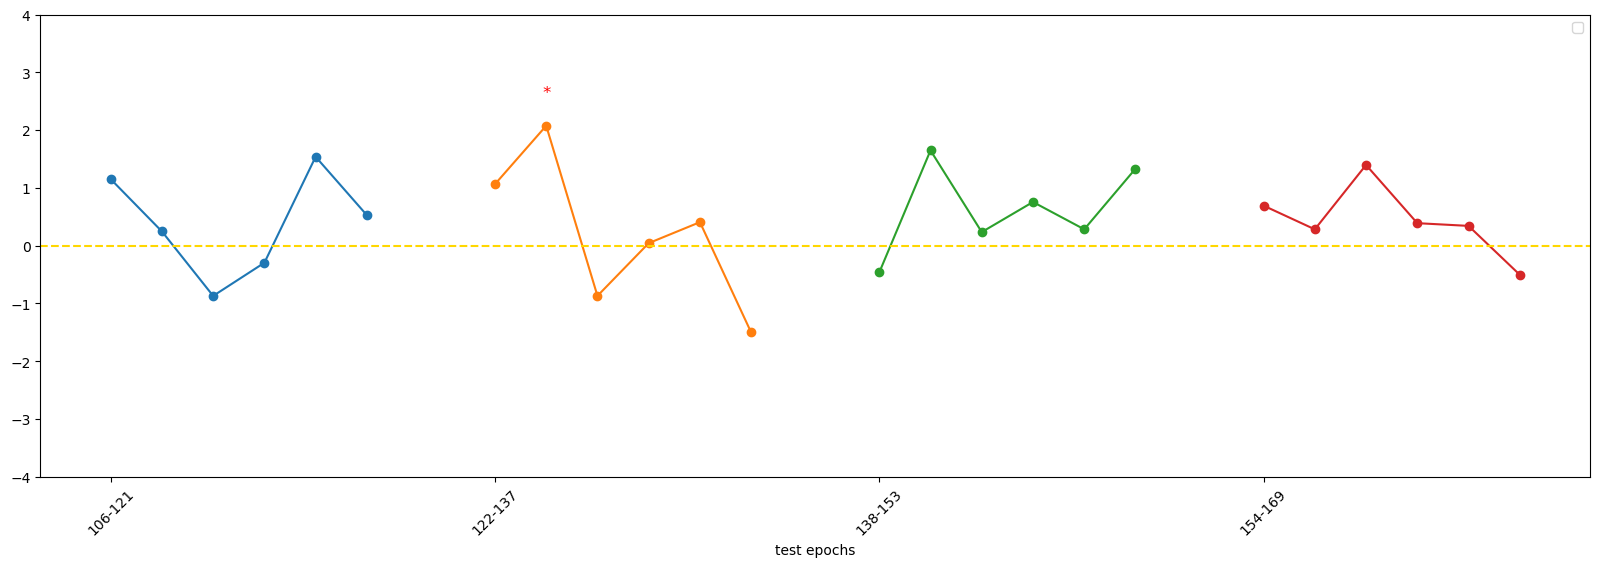

In [49]:
plot_within_cv_results(stats_tables, pval_tables, diff_edges, all_long_delay_epochs[1:])

##  Finally, get all cross phase train-test biases for medium serial diff

In [50]:
n_epochs = len(all_long_delay_epochs)
epoch_ids = np.arange(n_epochs)
all_cross_phase_results = {
    pname: np.zeros((n_epochs, n_epochs, len(diff_edges)-1)) for pname in ['tstats', 'p_values', 'mean_errs', 'err_scale']
} 

for train_epoch_id in epoch_ids:
    for test_epoch_id in epoch_ids:
        train_epoch, test_epoch = all_long_delay_epochs[train_epoch_id], all_long_delay_epochs[test_epoch_id]
        all_preds, all_gts, all_prs = across_epoch_test(epoch1, epoch2)
        diff_edges, tstats, p_values, mean_errs, err_scale = compute_serial_bias_in_fitting_result(all_preds, all_gts, all_prs)
    
        all_cross_phase_results['tstats'][train_epoch_id, test_epoch_id, :] = tstats
        all_cross_phase_results['p_values'][train_epoch_id, test_epoch_id, :] = p_values
        all_cross_phase_results['mean_errs'][train_epoch_id, test_epoch_id, :] = mean_errs
        all_cross_phase_results['err_scale'][train_epoch_id, test_epoch_id] = err_scale

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:02<00:00, 11.52it/s]


In [51]:
def annotate_cross_phase_plot(ax, n_epochs):
    ax.set_xticks(np.arange(n_epochs))
    ax.set_yticks(np.arange(n_epochs))
    ax.set_ylabel('Train Epoch')
    ax.set_xlabel('Test Epoch')

def plot_a_sd_band(sd_band_id):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    n_epochs = len(all_long_delay_epochs)

    # plot average bias
    ax = axs[0]
    ax.imshow(all_cross_phase_results['mean_errs'][:, :, sd_band_id], cmap='coolwarm', vmin=-4, vmax=4)
    annotate_cross_phase_plot(ax, n_epochs)
    ax.set_title('Average serial bias')

    # plot stats
    ax = axs[1]
    ax.imshow(all_cross_phase_results['tstats'][:, :, sd_band_id], cmap='coolwarm', vmin=-4, vmax=4)
    annotate_cross_phase_plot(ax, n_epochs)
    ax.set_title('T-Stats for serial bias')

    # plot p values
    ax = axs[2]
    pval_mask = all_cross_phase_results['p_values'][:, :, sd_band_id] < 0.05
    ax.imshow(pval_mask, cmap='hot', vmin=0, vmax=1)
    annotate_cross_phase_plot(ax, n_epochs)
    ax.set_title('Significance for serial bias')

    # plot err scale
    ax = axs[3]
    ax.imshow(1/all_cross_phase_results['err_scale'][:, :, 0], cmap='hot', vmin=0.022, vmax=0.03)
    annotate_cross_phase_plot(ax, n_epochs)
    ax.set_title('Decoding quality')

    plt.suptitle(f'Serial Diff Band {diff_edges[sd_band_id]:.0f}-{diff_edges[sd_band_id+1]:.0f}')

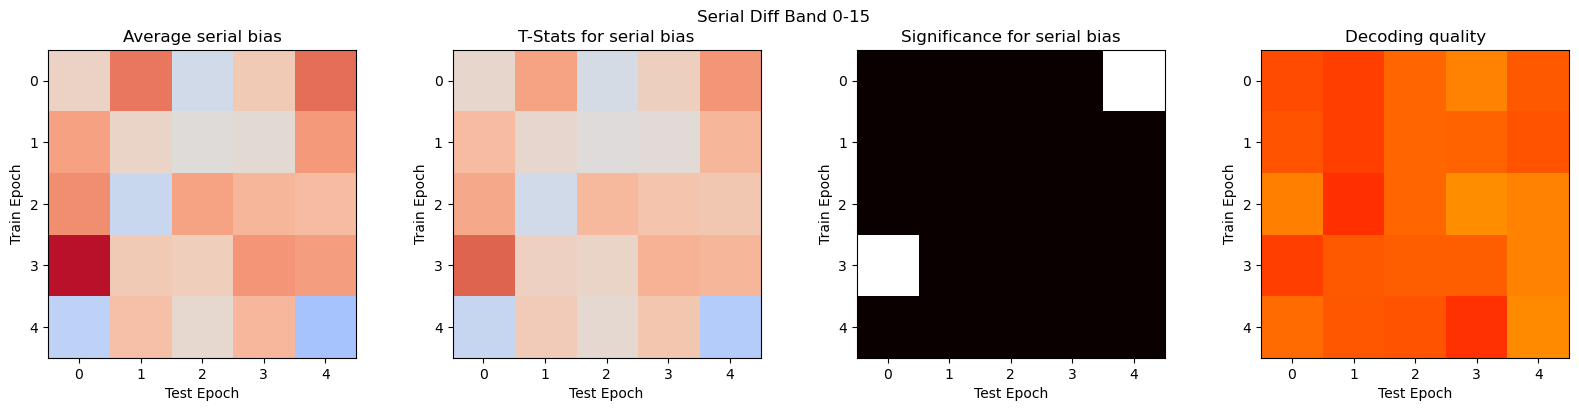

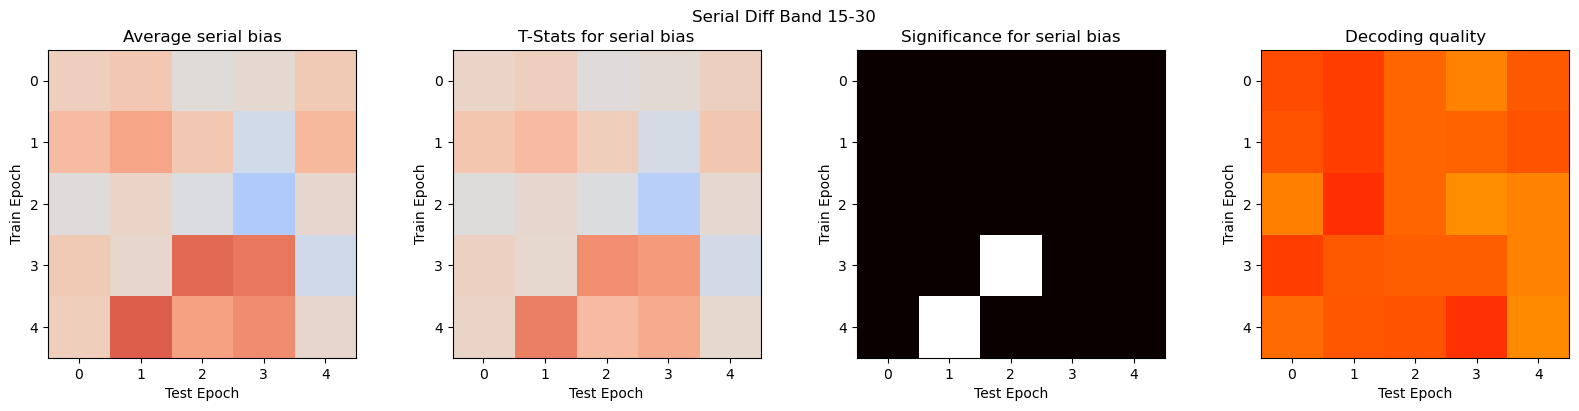

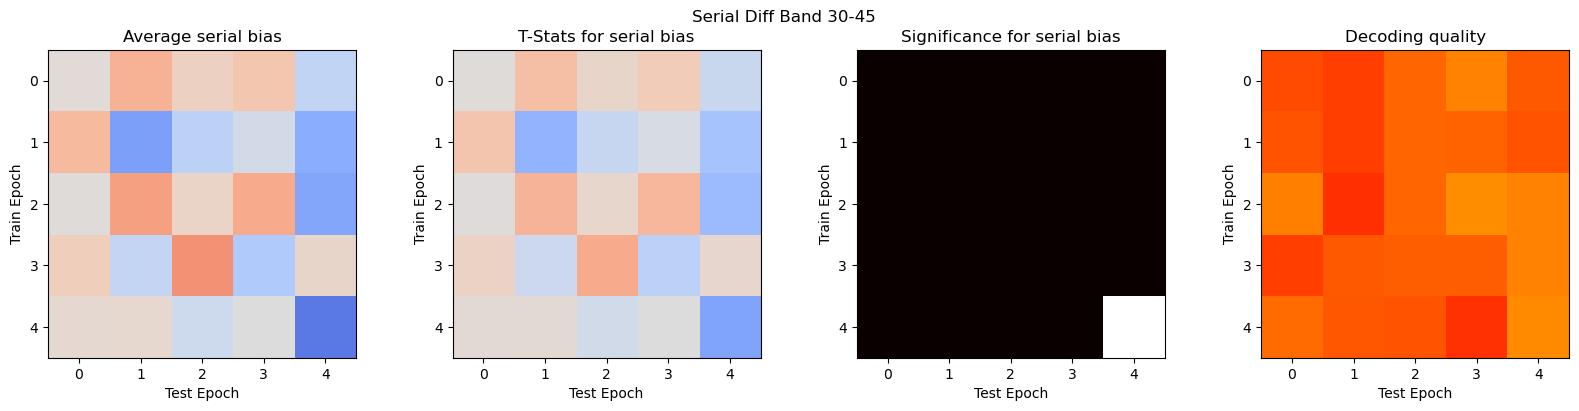

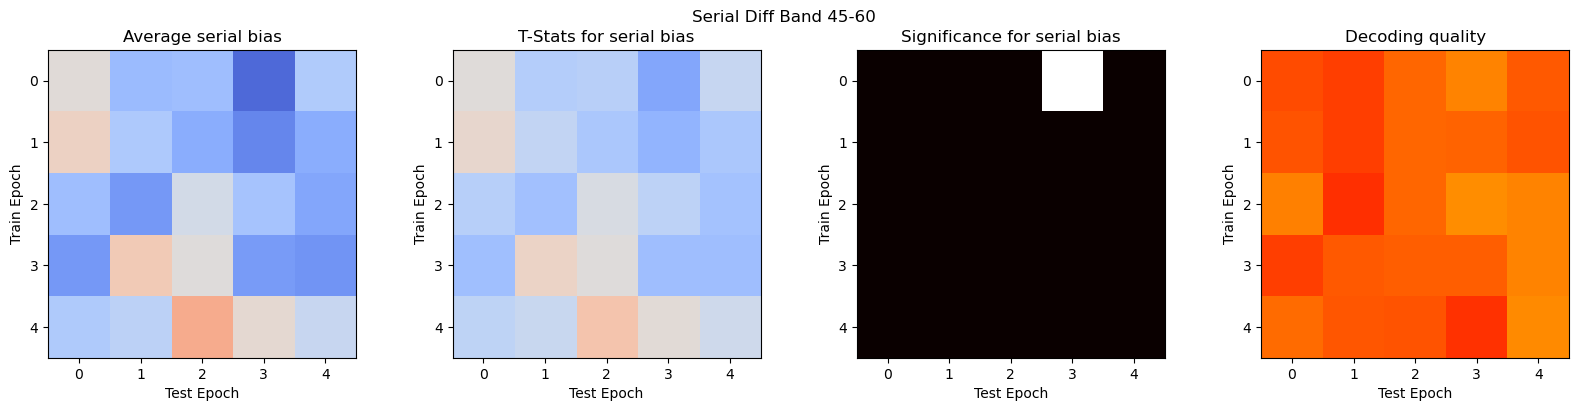

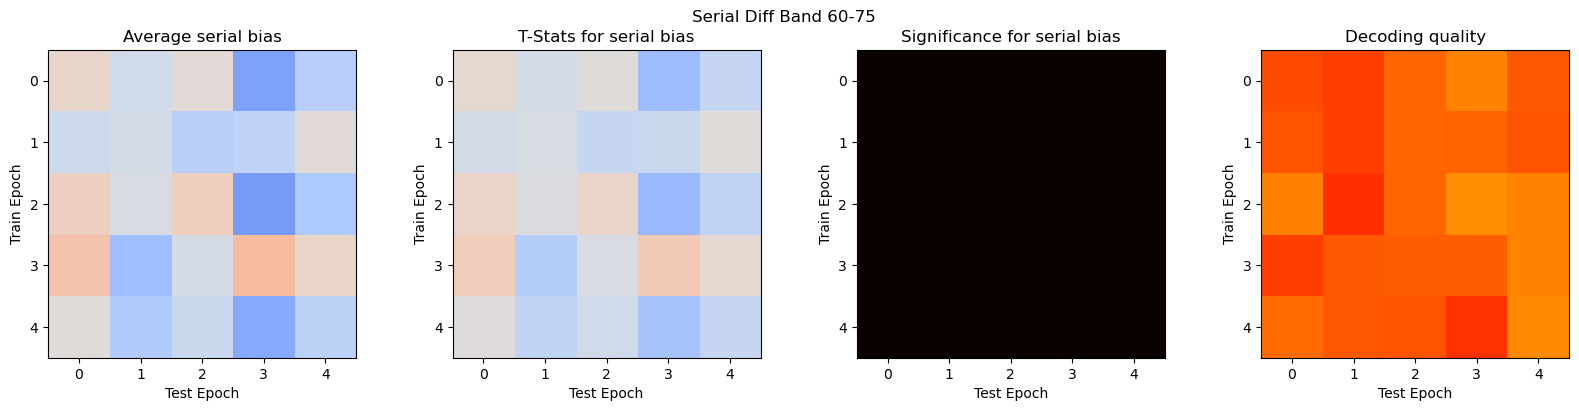

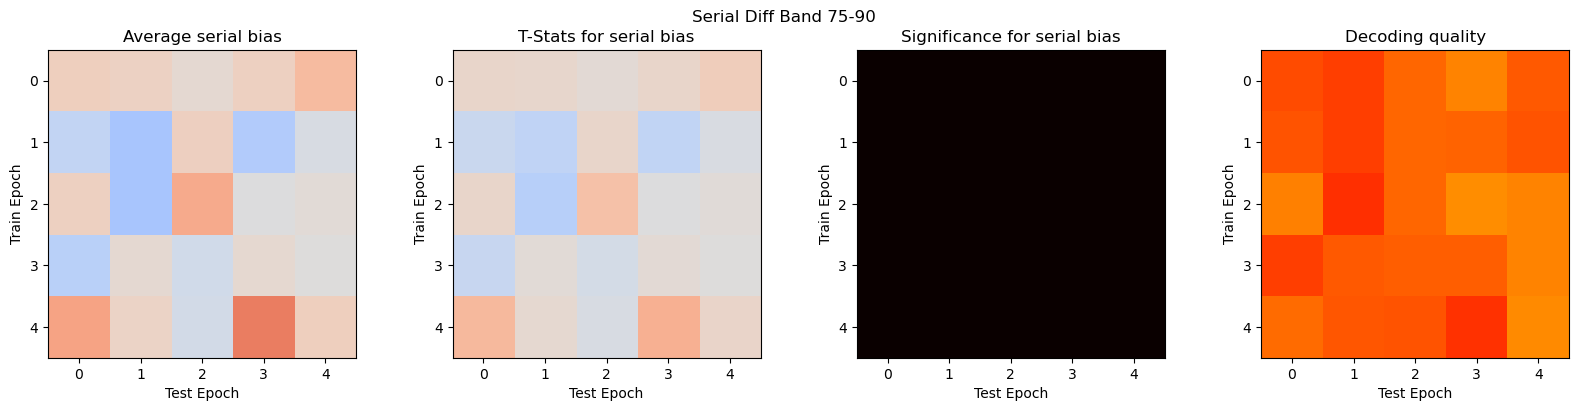

In [52]:
for sd_band_id in range(len(diff_edges)-1):
    plot_a_sd_band(sd_band_id)

In [53]:
print(list(all_cross_phase_results.keys()))
print(all_cross_phase_results['tstats'].shape)

['tstats', 'p_values', 'mean_errs', 'err_scale']
(5, 5, 6)


/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.

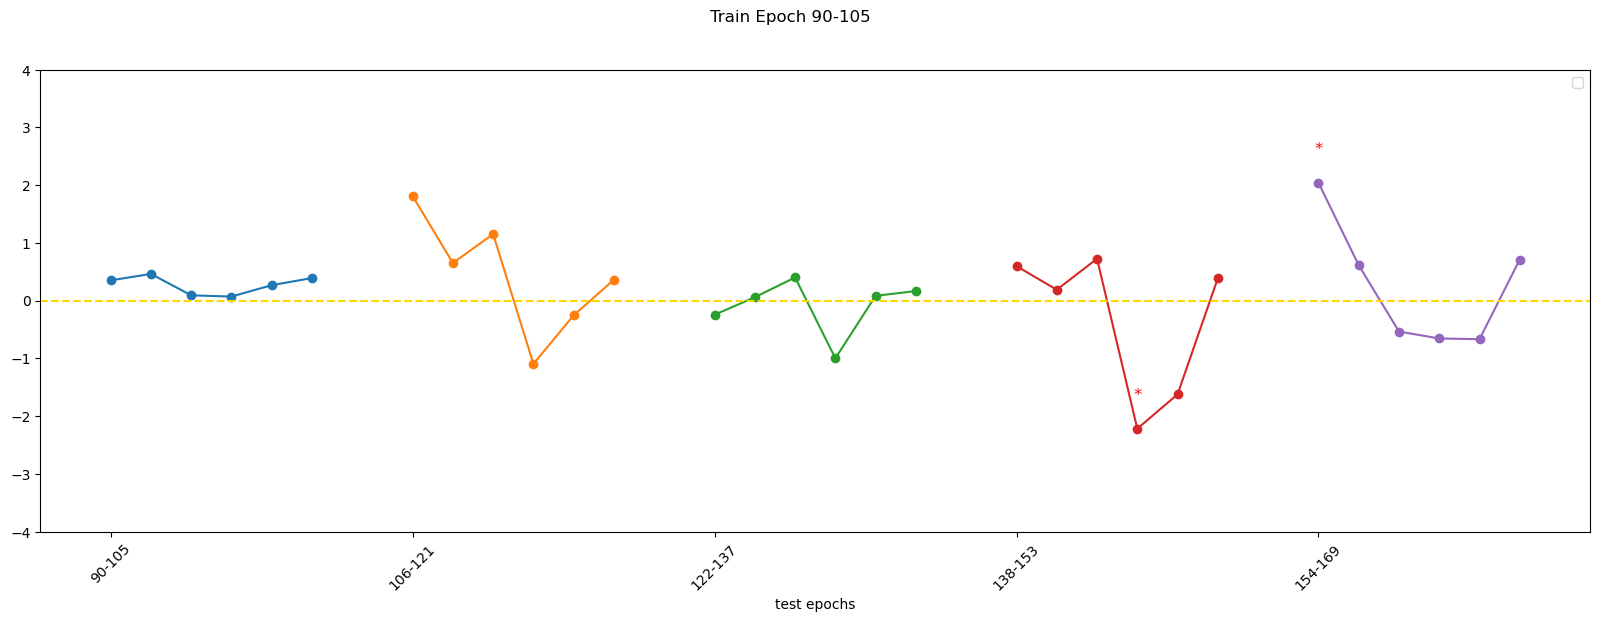

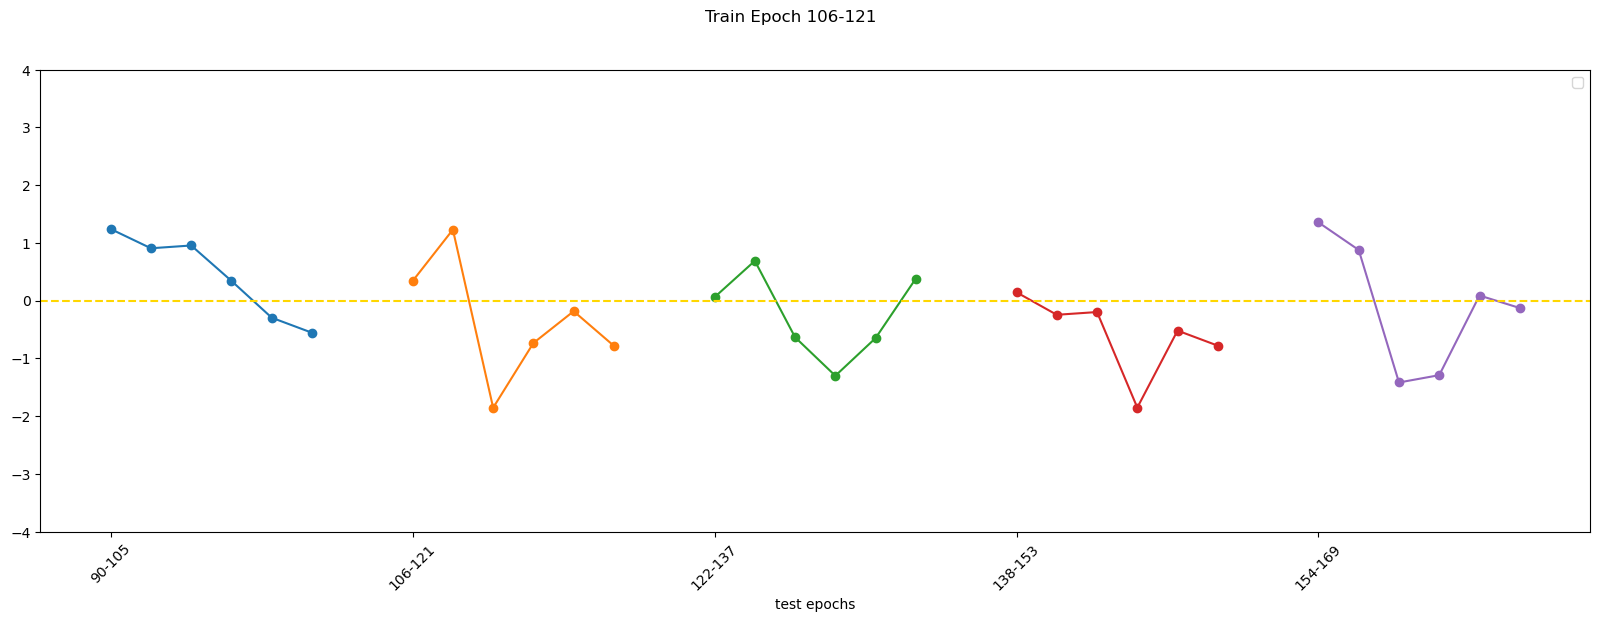

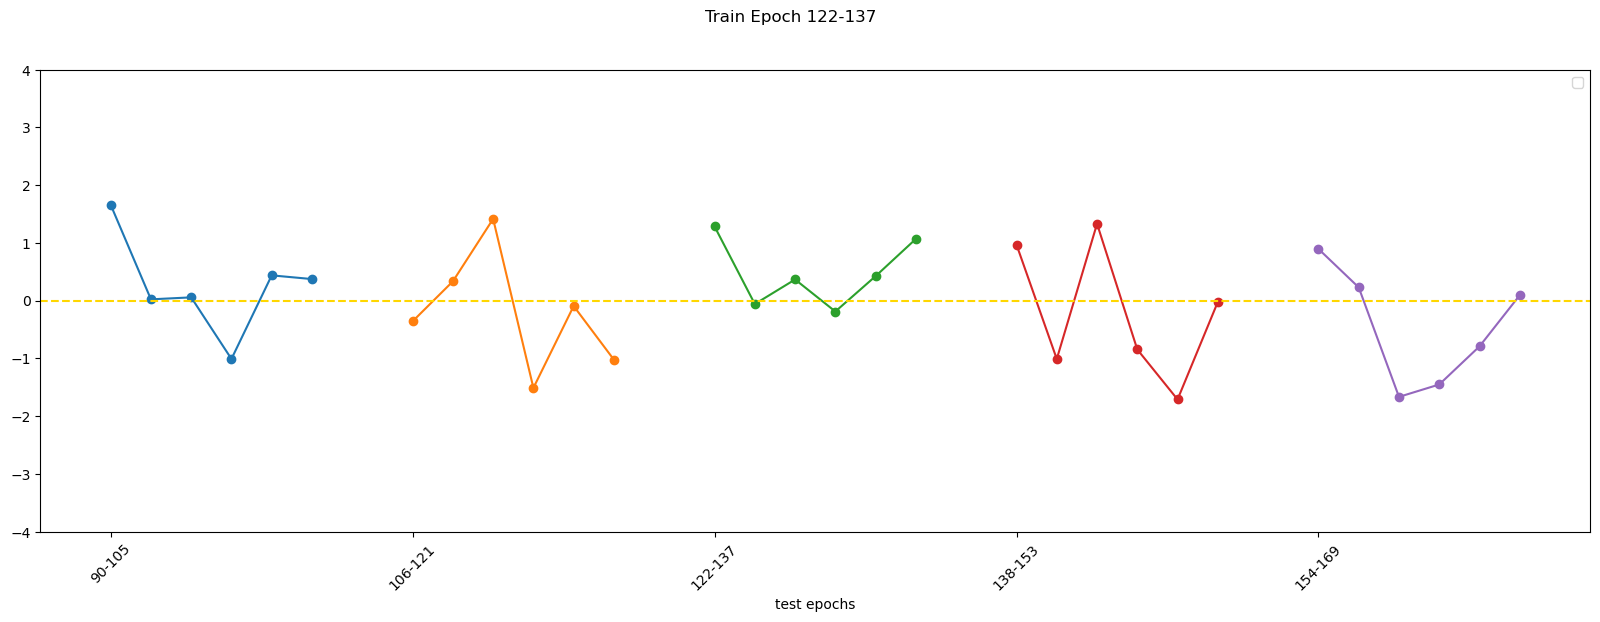

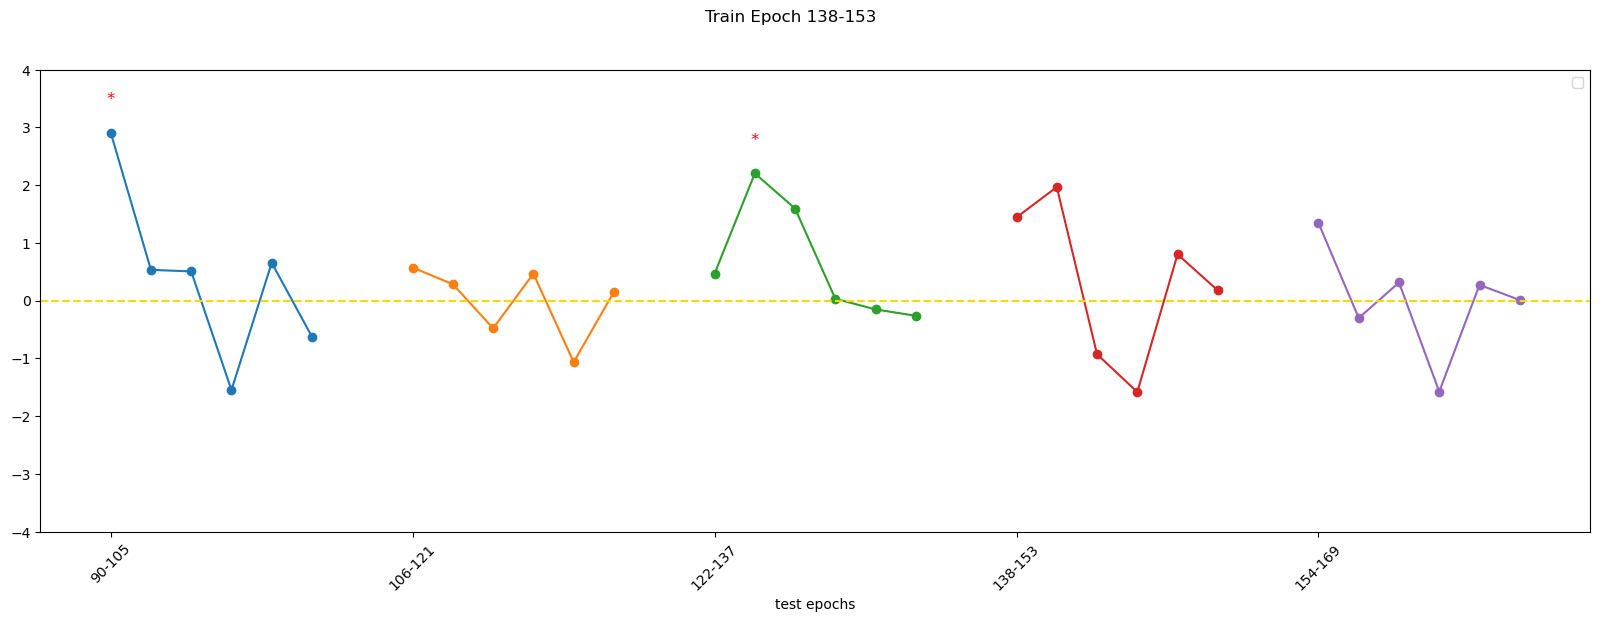

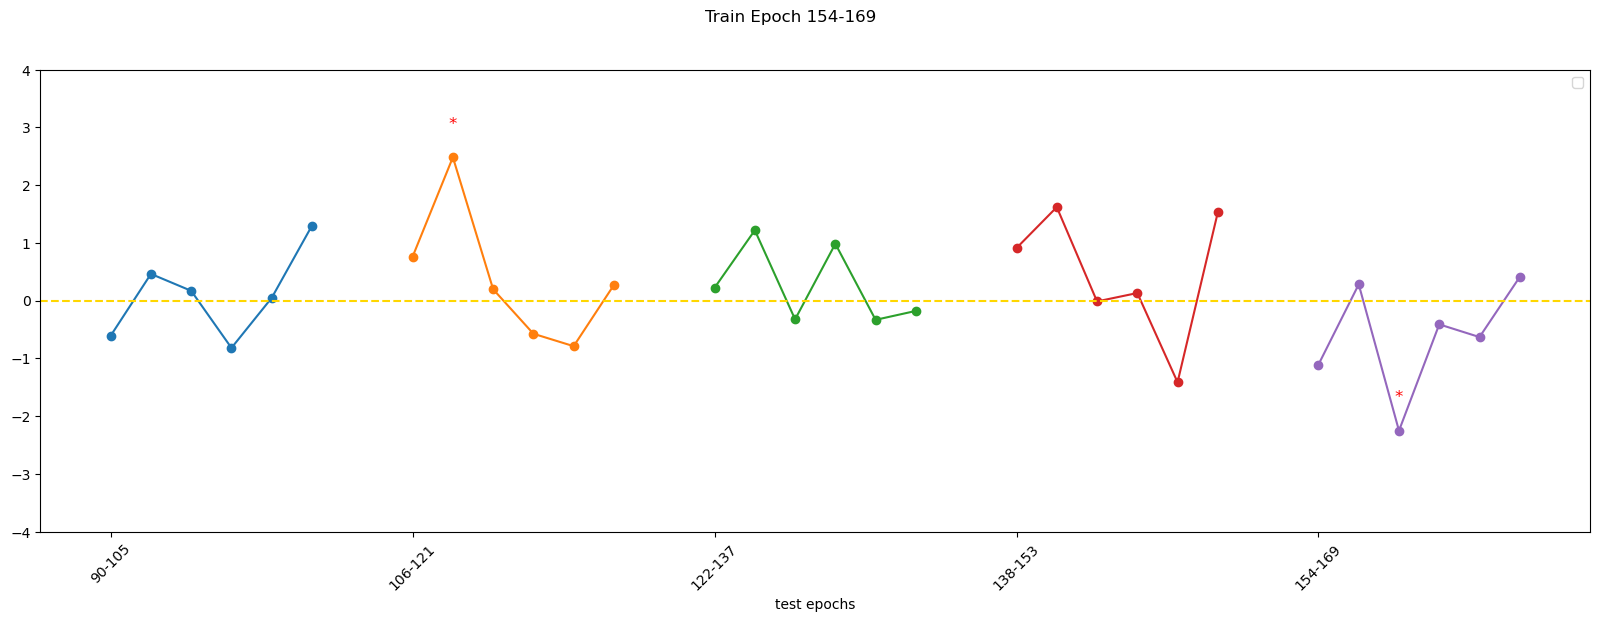

In [54]:
for train_idx in range(n_epochs):
    plot_within_cv_results(
        all_cross_phase_results['tstats'][train_idx],
        all_cross_phase_results['p_values'][train_idx], diff_edges,
        all_long_delay_epochs)
    plt.suptitle(f'Train Epoch {all_long_delay_epochs[train_idx][0]}-{all_long_delay_epochs[train_idx][-1]}')

### Combine everyone -- train one model

In [55]:
def across_subj_cross_phase_train_test(subjs, phase1, phase2, feature_mask, kfold):
    # load for both s1 and s2
    all_subj_lst = []
    xs1, xs2, ys1, ys2, df = [], [], [], [], []
    for subj in subjs:
        x1, y1, subj_df = load_one_stim_data(subj, phase1)
        x2, y2, _ = load_one_stim_data(subj, phase2)
    
        # truncate it a bit for now
        x1 = x1.T[feature_mask].T
        x2 = x2.T[feature_mask].T

        # add to list
        xs1.append(x1)
        xs2.append(x2)
        ys1.append(y1)
        ys2.append(y2)
        df.append(subj_df)
        all_subj_lst += [subj for _ in range(len(y1))]

    xs1 = np.concatenate(xs1, axis=0)
    xs2 = np.concatenate(xs2, axis=0)
    ys1 = np.concatenate(ys1, axis=0)
    ys2 = np.concatenate(ys2, axis=0)
    all_subj_lst = np.array(all_subj_lst)
    df = pd.concat(df, axis=0, ignore_index=True)

    # cv
    N_data = len(ys1)
    subj_indices = subjs.copy()
    np.random.shuffle(subj_indices)  # Shuffle to randomize assignment
    subj_test_indices = np.array_split(subj_indices, kfold)  # Split into n nearly equal parts
    preds = np.zeros(N_data)

    for i in range(kfold):
        # train and test mask
        test_subjs = subj_test_indices[i]
        test_subj_mask = np.isin(all_subj_lst, test_subjs)
        train_mask = np.full(N_data, True)
        train_mask[test_subj_mask] = False
        test_mask = np.full(N_data, False)
        test_mask[test_subj_mask] = True
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        # test
        fold_pred = svr_trigonometric_regression(fold_train_xs, fold_train_ys, fold_test_xs)
        preds[test_mask] = fold_pred

    return ys2, preds, df

In [56]:
def all_subj_across_epoch_test(epoch1, epoch2, kfold=5):
    # collect results
    all_gts, all_preds, df =across_subj_cross_phase_train_test(all_subjs, epoch1, epoch2, feature_mask, kfold=kfold)
    all_prs = df['prev_last_response'].to_numpy()

    return all_preds, all_gts, all_prs

In [57]:
n_epochs = len(all_long_delay_epochs)
epoch_ids = np.arange(n_epochs)
all_cross_subject_cross_phase_results = {
    pname: np.zeros((n_epochs, n_epochs, len(diff_edges)-1)) for pname in ['tstats', 'p_values', 'mean_errs', 'err_scale']
}

for train_epoch_id in epoch_ids:
    for test_epoch_id in epoch_ids:
        train_epoch, test_epoch = all_long_delay_epochs[train_epoch_id], all_long_delay_epochs[test_epoch_id]
        all_preds, all_gts, all_prs = all_subj_across_epoch_test(epoch1, epoch2)
        diff_edges, tstats, p_values, mean_errs, err_scale = compute_serial_bias_in_fitting_result(all_preds, all_gts, all_prs)
    
        all_cross_subject_cross_phase_results['tstats'][train_epoch_id, test_epoch_id, :] = tstats
        all_cross_subject_cross_phase_results['p_values'][train_epoch_id, test_epoch_id, :] = p_values
        all_cross_subject_cross_phase_results['mean_errs'][train_epoch_id, test_epoch_id, :] = mean_errs
        all_cross_subject_cross_phase_results['err_scale'][train_epoch_id, test_epoch_id] = err_scale

Text(0.5, 1.0, 'Decoding quality')

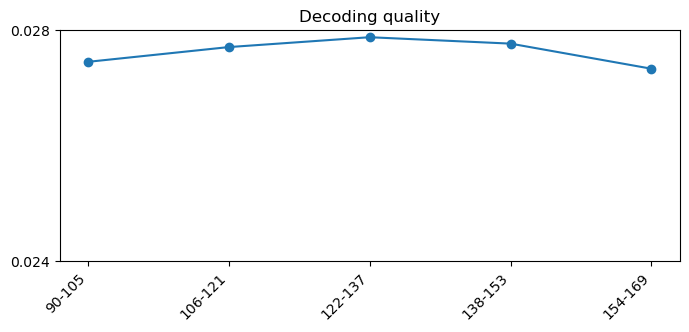

In [64]:
# check the 'quality' at different phases
fig, ax = plt.subplots(1, figsize=(8, 3))
quality = []
for i in range(len(epoch_ids)):
    err_scale = all_cross_subject_cross_phase_results['err_scale'][i, i]
    quality.append(1 / np.mean(err_scale))
time_point_labels = [f'{phase[0]}-{phase[-1]}' for phase in all_long_delay_epochs]
ax.plot(np.arange(len(quality)), quality, linestyle='-', marker='o')
_ = ax.set_xticks(np.arange(len(quality)))
_ = ax.set_xticklabels(time_point_labels, rotation=45, ha='right')
_ = ax.set_yticks([0.024, 0.028])
ax.set_title('Decoding quality')

/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_2462948/1181076917.py:39: UserWarning: No artists with labels found to put in legend.

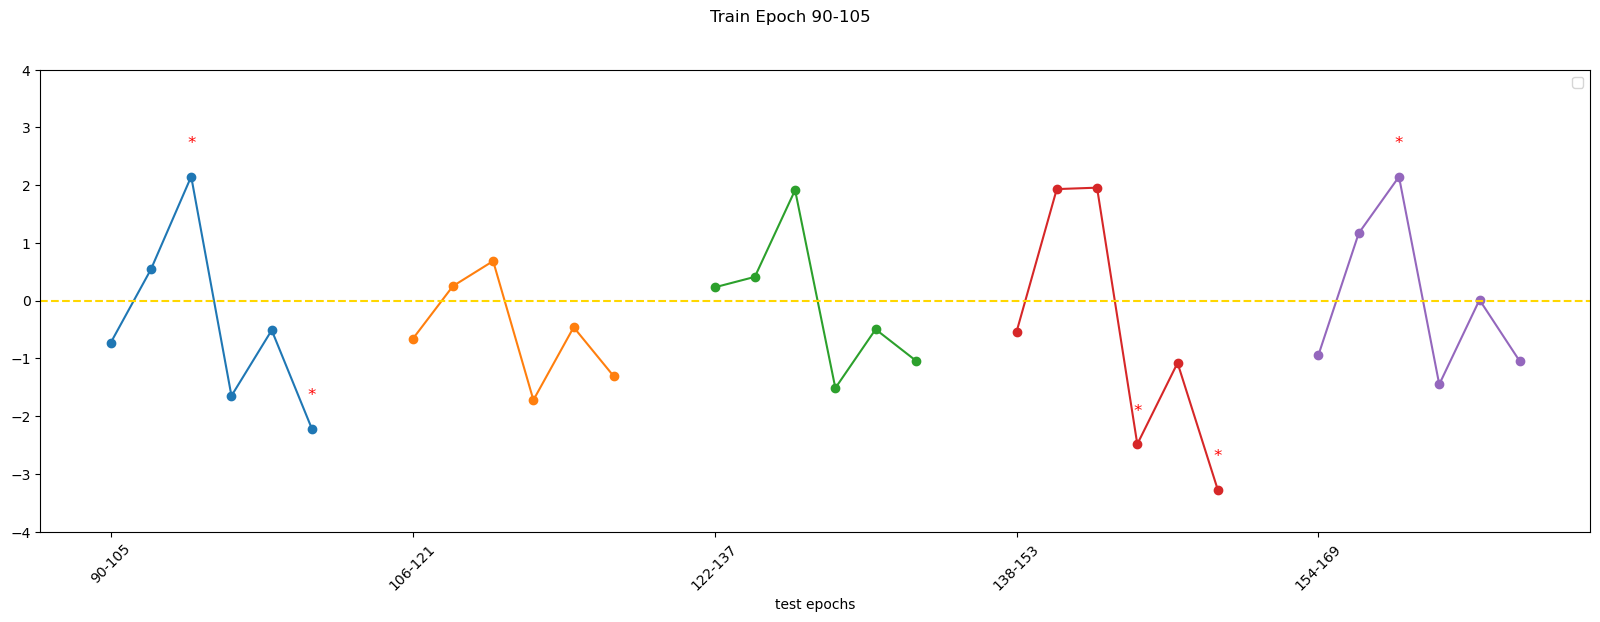

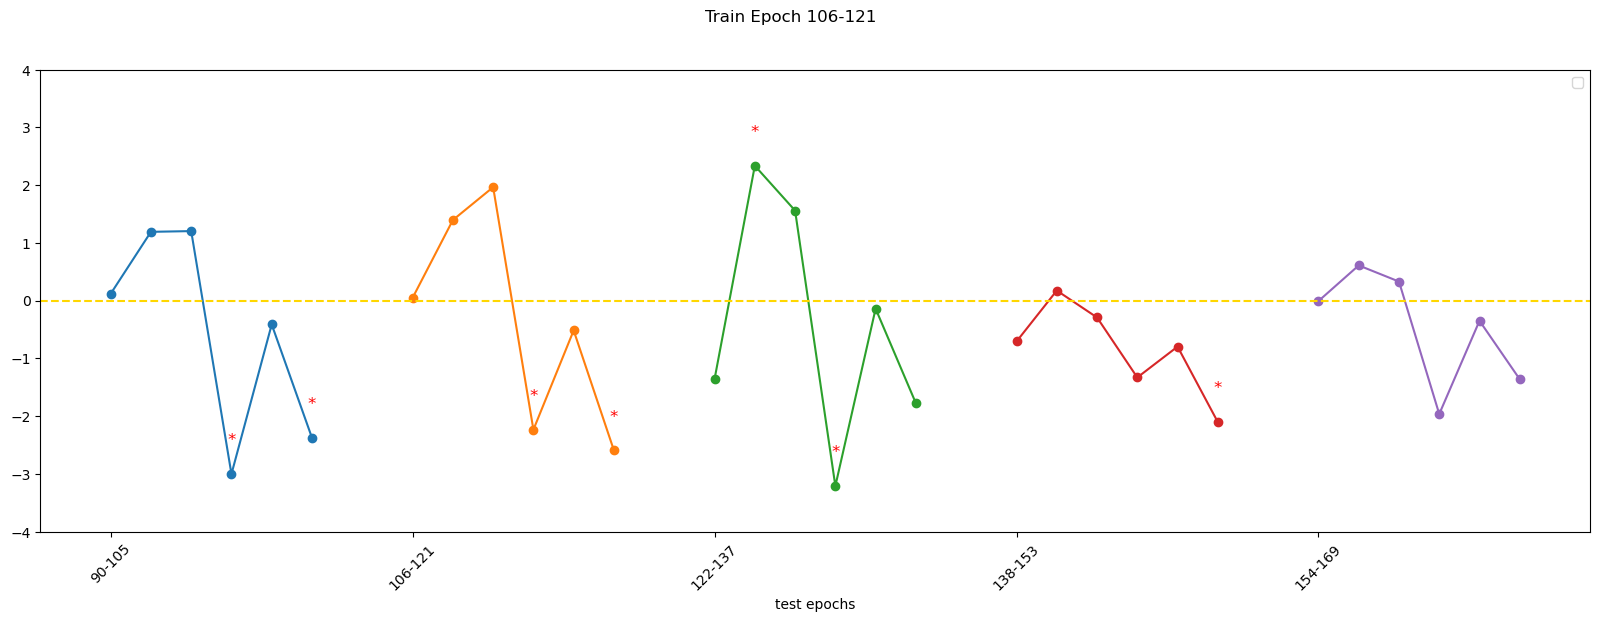

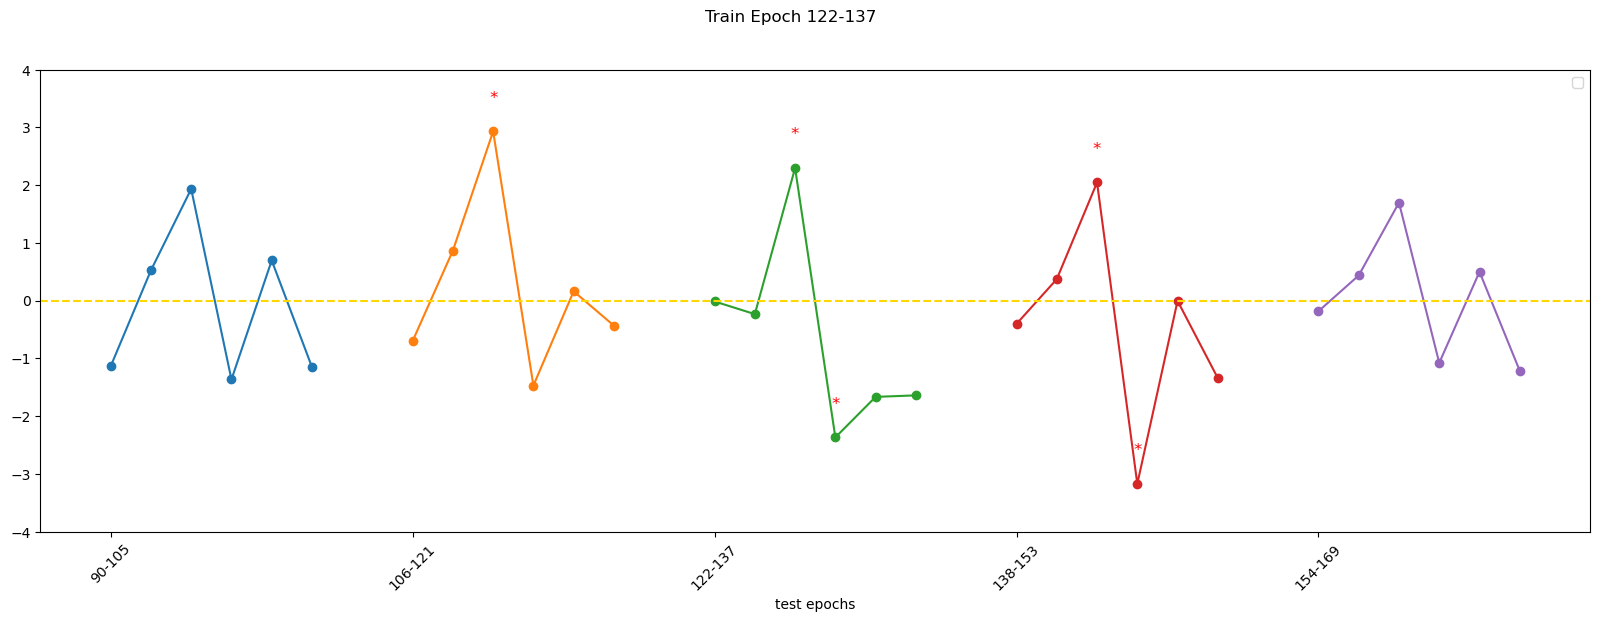

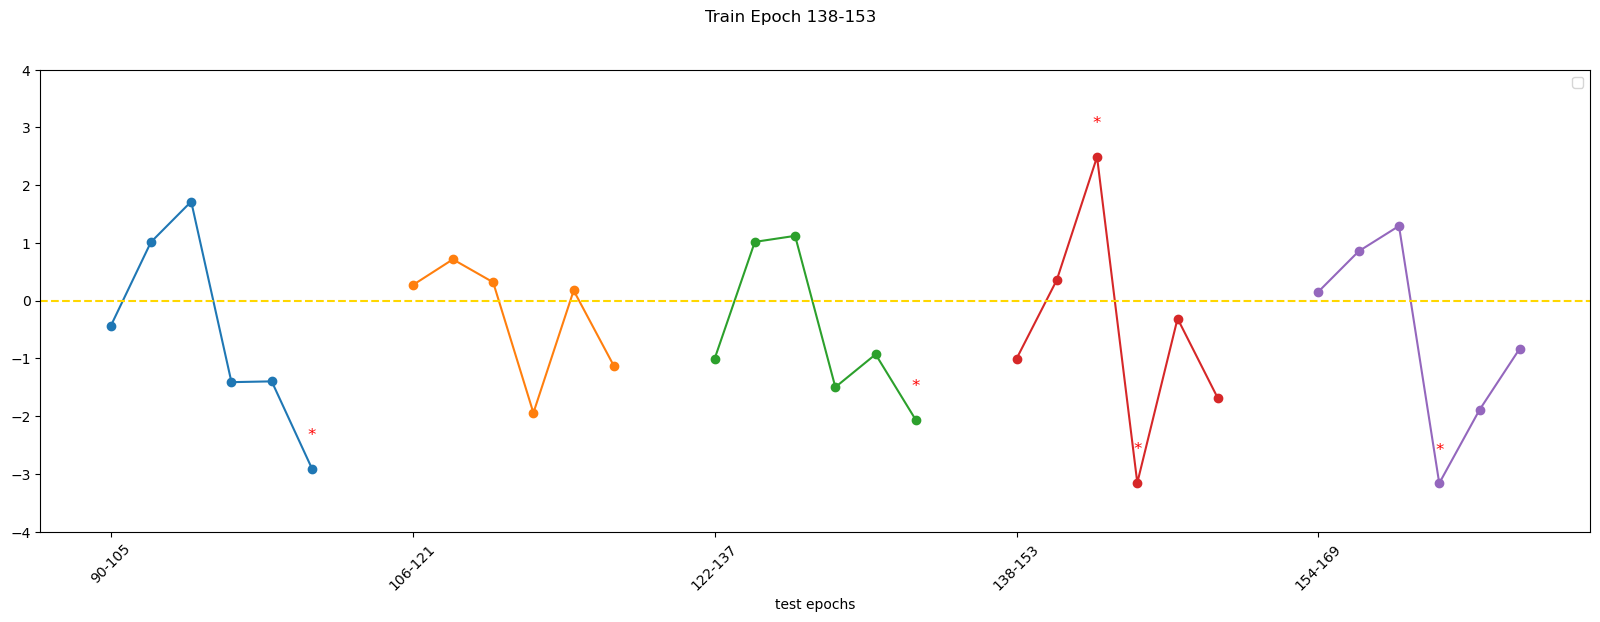

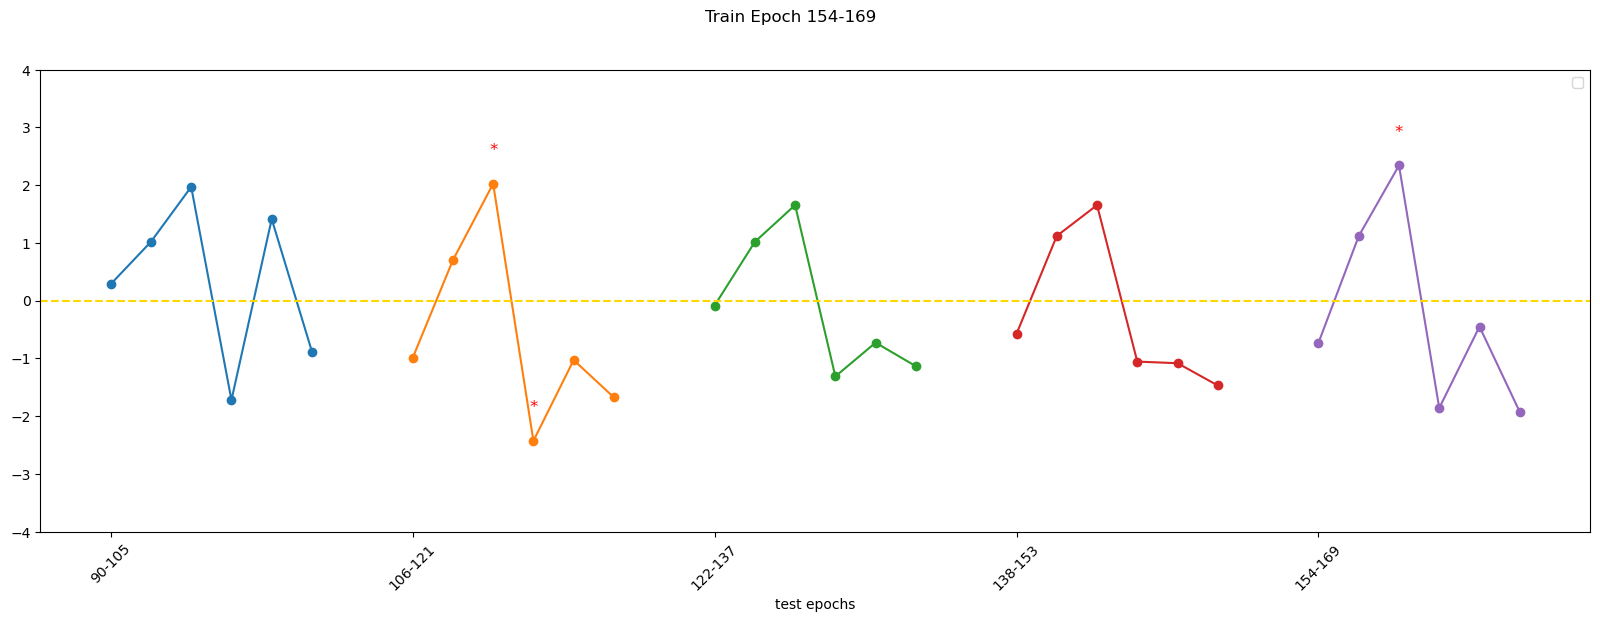

In [65]:
for train_idx in range(n_epochs):
    plot_within_cv_results(
        all_cross_subject_cross_phase_results['tstats'][train_idx],
        all_cross_subject_cross_phase_results['p_values'][train_idx], diff_edges,
        all_long_delay_epochs)
    plt.suptitle(f'Train Epoch {all_long_delay_epochs[train_idx][0]}-{all_long_delay_epochs[train_idx][-1]}')

### Compare hand activity and eye accuracy

In [66]:
hand_activity_dir = '../stats/mouse'

In [67]:
def bin_data(data, time_bin):
    shape_original = data.shape
    t_original = shape_original[-1]
    n_bins = t_original // time_bin
    data = data[..., :n_bins * time_bin]
    data = data.reshape(*shape_original[:-1], n_bins, time_bin)
    return data

In [68]:
def load_condition_mouse_activity(condition, time_bin=50):
    # select subjects
    fp = os.path.join(hand_activity_dir, f'{condition}.npz')
    loaded = np.load(fp)
    selected = np.array([loaded[str(subj)] for subj in all_subjs])

    # binning
    binned = bin_data(selected, time_bin=time_bin)
    binned = np.mean(binned, axis=-1)

    return binned

In [69]:
avg_hand_motions = np.mean(
    [
        load_condition_mouse_activity('click_cued'),
        load_condition_mouse_activity('click_null'),
        load_condition_mouse_activity('draw_cued'),
        load_condition_mouse_activity('draw_null'),
    ], axis=0)

In [70]:
delay_1_mouse_motion = avg_hand_motions.T[delay_1_epoch].mean(axis=0)
delay_2_mouse_motion = avg_hand_motions.T[delay_2_epoch].mean(axis=0)

33


(array([[-0.03294021,  0.36719026],
        [-7.39761093,  4.80882857]]),
 array([0.09844097, 0.66833837]))

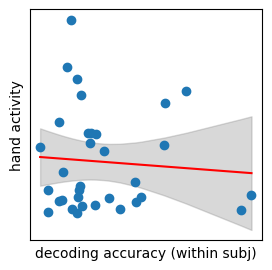

In [71]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l2 = np.array(delay_1_mouse_motion)

l1 = 1 / l1

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('decoding accuracy (within subj)')
ax.set_ylabel('hand activity')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

33


(array([[  0.04283047,   0.44057669],
        [-11.52480321,   2.90484902]]),
 array([0.01883096, 0.23227865]))

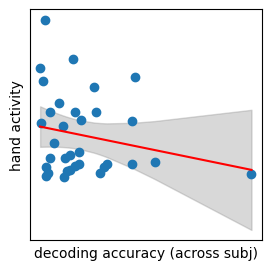

In [72]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([heldout_eye_err_scale[subj] for subj in all_subjs])
l2 = np.array(delay_1_mouse_motion)

l1 = 1 / l1

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('decoding accuracy (across subj)')
ax.set_ylabel('hand activity')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

33


(array([[ 7.14656435e-05,  2.83371072e-01],
        [-2.16801071e+00,  1.70771551e+00]]),
 array([0.04989148, 0.81020506]))

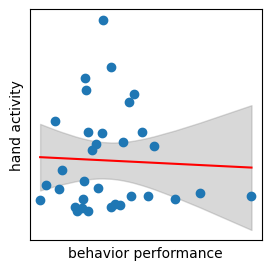

In [73]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([behav_err_scale[subj] for subj in all_subjs])
l2 = np.array(delay_1_mouse_motion)

l1 = 1 / l1

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('behavior performance')
ax.set_ylabel('hand activity')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

### Now instead of checking hand movement frequency, we check other metrics

#### hand movement relevance

In [74]:
relevance_data_delay_1 = np.load('../stats/mouse/mouse_relevance_delay_1.npz')
relevance_data_delay_1 = [relevance_data_delay_1[str(subj)].item() for subj in all_subjs]

In [75]:
relevance_data_delay_2 = np.load('../stats/mouse/mouse_relevance_delay_2.npz')
relevance_data_delay_2 = [relevance_data_delay_2[str(subj)].item() for subj in all_subjs]

33


(array([[ -0.19794778,   0.71944839],
        [-10.94765939,  17.03856455]]),
 array([0.25515528, 0.66021343]))

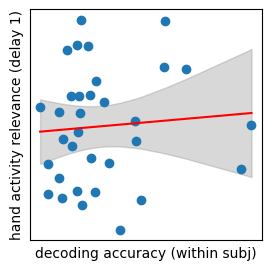

In [76]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l2 = np.array(relevance_data_delay_1)

l1 = 1 / l1

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('decoding accuracy (within subj)')
ax.set_ylabel('hand activity relevance (delay 1)')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

33


(array([[-0.2099212 ,  0.32171885],
        [-4.72163123, 11.49665925]]),
 array([0.67097221, 0.40075595]))

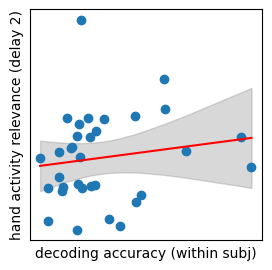

In [77]:
fig, ax = plt.subplots(1, figsize=(3, 3))
l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l2 = np.array(relevance_data_delay_2)

l1 = 1 / l1

print(len(l1))

ax.plot(l1, l2, 'o')
ax.set_xlabel('decoding accuracy (within subj)')
ax.set_ylabel('hand activity relevance (delay 2)')
ax.set_yticks([])
ax.set_xticks([])
display_regression(ax, l1, l2)

### Split two modes?

In [81]:
mode_behav_errs = {
    'draw': {},
    'click': {},
}
mode_decoding_within_errs = {
    'draw': {},
    'click': {},
}
mode_decoding_across_errs = {
    'draw': {},
    'click': {},
}

for subj in all_subjs:
    for mode in ['draw', 'click']:
        mask = (behav_dfs[subj]['mode'] == mode).to_numpy()
        mode_behav_errs[mode][subj] = get_err_distrib_scale(behav_errors[subj][mask])
        mode_decoding_within_errs[mode][subj] = get_err_distrib_scale(eyetrack_errs[subj][mask])
        mode_decoding_across_errs[mode][subj] = get_err_distrib_scale(eyetrack_holdout_errs[subj][mask])
        


(array([[ 0.01022079,  0.08721607],
       [-0.59219613,  1.87053839]]), array([0.01480751, 0.29793483]))
(array([[ 0.0193215 ,  0.0869296 ],
       [-0.38489934,  1.50184297]]), array([0.00312198, 0.23641628]))


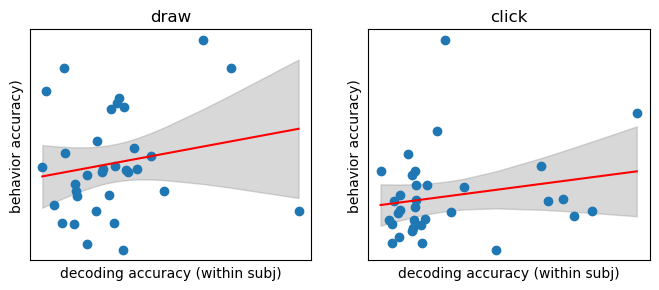

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, mode in enumerate(['draw', 'click']):
    ax = axs[i]
    l2 = np.array([mode_behav_errs[mode][subj] for subj in all_subjs])
    l1 = np.array([mode_decoding_within_errs[mode][subj] for subj in all_subjs])

    l1 = 1 / l1
    l2 = 1 / l2

    ax.plot(l1, l2, 'o')
    ax.set_xlabel('decoding accuracy (within subj)')
    ax.set_ylabel('behavior accuracy)')
    ax.set_yticks([])
    ax.set_xticks([])
    rr = display_regression(ax, l1, l2)
    print(rr)
    ax.set_title(mode)

(array([[ 0.025823  ,  0.0917304 ],
       [-0.86783357,  1.60151262]]), array([0.00098854, 0.54894673]))
(array([[ 0.00334753,  0.09359172],
       [-0.71562906,  2.39943113]]), array([0.036108  , 0.27876009]))


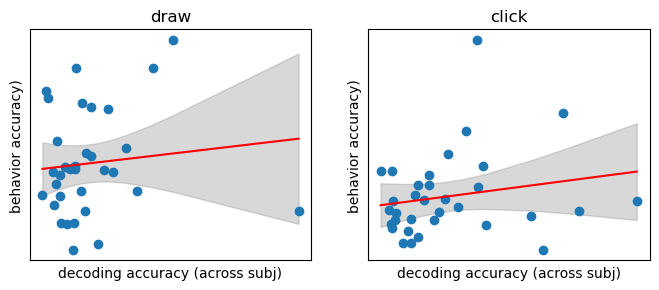

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, mode in enumerate(['draw', 'click']):
    ax = axs[i]
    l2 = np.array([mode_behav_errs[mode][subj] for subj in all_subjs])
    l1 = np.array([mode_decoding_across_errs[mode][subj] for subj in all_subjs])

    l1 = 1 / l1
    l2 = 1 / l2

    ax.plot(l1, l2, 'o')
    ax.set_xlabel('decoding accuracy (across subj)')
    ax.set_ylabel('behavior accuracy)')
    ax.set_yticks([])
    ax.set_xticks([])
    rr = display_regression(ax, l1, l2)
    print(rr)
    ax.set_title(mode)

In [90]:
mode_hand_activity = {}
for mode in ['draw', 'click']:
    loaded = np.mean(
        [
            load_condition_mouse_activity(f'{mode}_cued'),
            load_condition_mouse_activity(f'{mode}_null'),
        ], axis=0)
    delay_1_ac = loaded.T[delay_1_epoch].mean(axis=0)
    delay_2_ac = loaded.T[delay_2_epoch].mean(axis=0)
    loaded = delay_1_ac + delay_2_ac
    mode_hand_activity[mode] = {subj: ha for subj, ha in zip(all_subjs, loaded)}

(array([[ 0.05552474,  0.07977587],
       [-0.02845524,  0.03265996]]), array([1.34438573e-12, 8.89316218e-01]))
(array([[ 0.06027933,  0.08761472],
       [-0.05577596,  0.03854453]]), array([2.90190113e-12, 7.11982333e-01]))


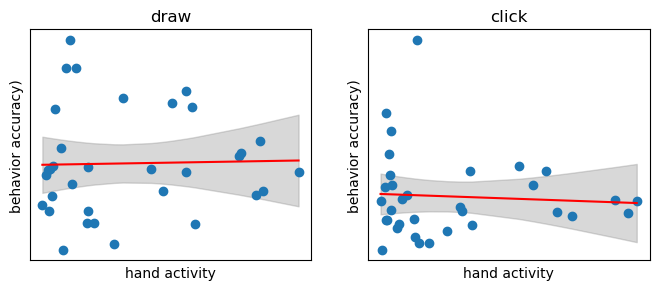

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, mode in enumerate(['draw', 'click']):
    ax = axs[i]
    l2 = np.array([mode_behav_errs[mode][subj] for subj in all_subjs])
    l1 = np.array([mode_hand_activity[mode][subj] for subj in all_subjs])

    l2 = 1 / l2

    ax.plot(l1, l2, 'o')
    ax.set_xlabel('hand activity')
    ax.set_ylabel('behavior accuracy)')
    ax.set_yticks([])
    ax.set_xticks([])
    rr = display_regression(ax, l1, l2)
    print(rr)
    ax.set_title(mode)

(array([[ 0.02768479,  0.03474789],
       [-0.01100281,  0.00679688]]), array([5.49382923e-18, 6.33246898e-01]))
(array([[ 0.02966103,  0.04003811],
       [-0.02088147,  0.01492455]]), array([1.08063392e-14, 7.36666765e-01]))


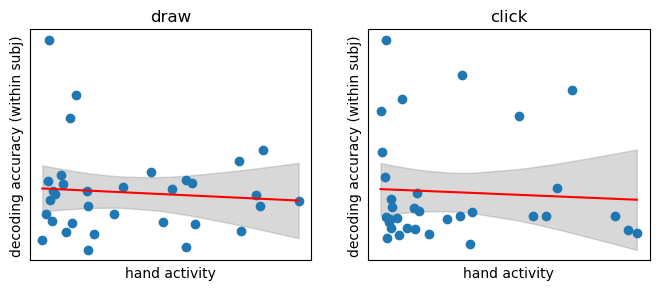

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, mode in enumerate(['draw', 'click']):
    ax = axs[i]
    l2 = np.array([mode_decoding_within_errs[mode][subj] for subj in all_subjs])
    l1 = np.array([mode_hand_activity[mode][subj] for subj in all_subjs])

    l2 = 1 / l2

    ax.plot(l1, l2, 'o')
    ax.set_xlabel('hand activity')
    ax.set_ylabel('decoding accuracy (within subj)')
    ax.set_yticks([])
    ax.set_xticks([])
    rr = display_regression(ax, l1, l2)
    print(rr)
    ax.set_title(mode)

(array([[ 0.02393222,  0.03092521],
       [-0.01401859,  0.00360442]]), array([1.56858910e-16, 2.37232909e-01]))
(array([[ 0.02619628,  0.03241428],
       [-0.01606802,  0.00538713]]), array([8.78308053e-19, 3.17812800e-01]))


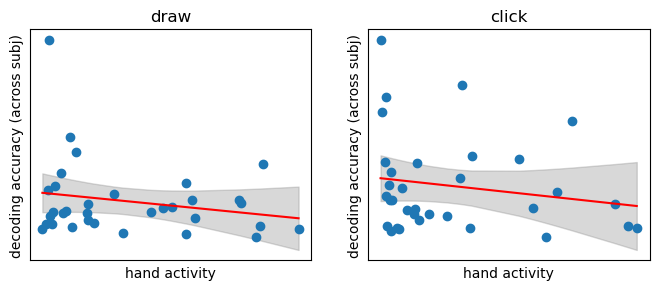

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, mode in enumerate(['draw', 'click']):
    ax = axs[i]
    l2 = np.array([mode_decoding_across_errs[mode][subj] for subj in all_subjs])
    l1 = np.array([mode_hand_activity[mode][subj] for subj in all_subjs])

    l2 = 1 / l2

    ax.plot(l1, l2, 'o')
    ax.set_xlabel('hand activity')
    ax.set_ylabel('decoding accuracy (across subj)')
    ax.set_yticks([])
    ax.set_xticks([])
    rr = display_regression(ax, l1, l2)
    print(rr)
    ax.set_title(mode)

#### Check other dynamic profile of actions

In [50]:
dynamic_profile_names = [
    'draw_delay_1', 'draw_delay_2', 'click_delay_1', 'click_delay_2'
]
dynamic_profiles = {}
for dname in dynamic_profile_names:
    loaded = pd.read_csv(f'../stats/mouse/dynamics_{dname}.csv')
    df_sorted = loaded[loaded['subject'].isin(all_subjs)]
    df_sorted_copy = df_sorted.copy()
    df_sorted_copy['subject'] = pd.Categorical(df_sorted['subject'], categories=all_subjs, ordered=True)
    df_sorted_copy = df_sorted_copy.sort_values('subject')
    dynamic_profiles[dname] =df_sorted_copy


In [ ]:
dynamic_profiles['draw_delay_2']

,subject,mag,duration,frequency,velocity,t_per_stop
0,908,91.275243,608.625000,4.793590,0.379357,52.000000
1,909,274.810473,785.980583,6.833741,2.816476,69.818350
2,910,211.726992,933.285714,2.894017,0.648529,78.666667
3,912,194.587223,686.360215,5.159325,1.347267,75.020332
4,913,171.424774,516.500000,5.063179,0.570180,66.500000
5,914,205.522976,537.118519,6.588189,1.959082,70.530159
6,915,226.452961,528.436893,7.118383,2.336065,69.046580
7,916,352.858455,834.123077,3.553736,1.456356,71.784369
8,917,175.717901,628.674419,6.565886,1.511720,67.746302
9,918,172.510926,620.288889,4.229281,0.870288,70.312169


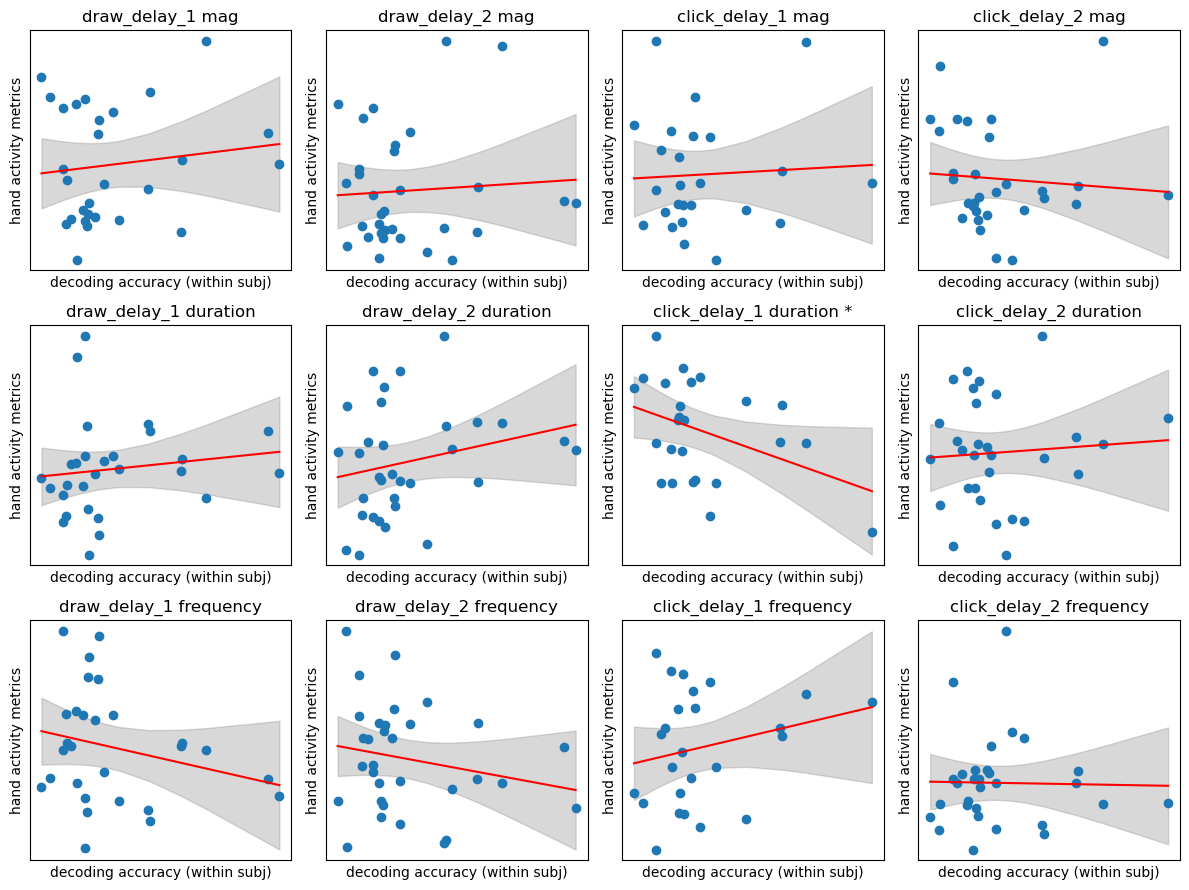

In [53]:
metrics = ['mag', 'duration', 'frequency']
nc, nr = len(dynamic_profiles), len(metrics)
fig, axs = plt.subplots(nr, nc, figsize=(nc*3, nr*3))

l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l1 = 1 / l1
for rid in range(nr):
    for cid in range(nc):
        ax = axs[rid, cid]
        profile_name, metric = dynamic_profile_names[cid], metrics[rid]

        subj_valid = dynamic_profiles[profile_name]['subject'].to_list()
        subj_mask = np.array([s in subj_valid for s in all_subjs])
        l2 = dynamic_profiles[profile_name][metric].to_numpy()
        l1_select = l1[subj_mask]
        
        ax.plot(l1_select, l2, 'o')
        ax.set_xlabel('decoding accuracy (within subj)')
        ax.set_ylabel('hand activity metrics')
        ax.set_yticks([])
        ax.set_xticks([])
        conf_int, pvals = display_regression(ax, l1_select, l2)
        title = f'{profile_name} {metric}'
        if pvals[1] < 0.05:
            title += ' *'
        ax.set_title(title)

        plt.tight_layout()

#### Which subject is missing?

In [103]:
misisng_subjs = {
    model_name: np.array([subj for subj in all_subjs if subj not in dynamic_data['subject'].to_list()]) 
    for model_name, dynamic_data in dynamic_profiles.items()
}
misisng_subjs

{'draw_delay_1': array([908, 913, 929, 931]),
 'draw_delay_2': array([921]),
 'click_delay_1': array([908, 913, 929, 930, 931, 933]),
 'click_delay_2': array([908, 930, 933])}

In [110]:
missing_count = {}
for model_name, missing_subjs in misisng_subjs.items():
    for subj in missing_subjs:
        if subj not in missing_count:
            missing_count[subj] = 0
        missing_count[subj] += 1
weird_subjs = [subj for subj, count in missing_count.items() if count >= 2]

### how do their behavioral data and eyetracking data compare with other?

[]

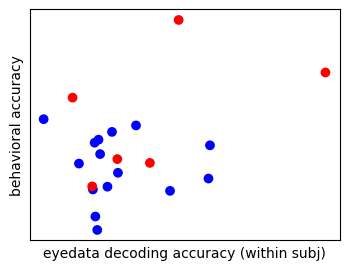

In [119]:
l1 = np.array([eye_err_scale[subj] for subj in all_subjs])
l2 = np.array([behav_err_scale[subj] for subj in all_subjs])
subj_colors = ['r' if subj in weird_subjs else 'b' for subj in all_subjs]
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.scatter(1/l1, 1/l2, c=subj_colors)
ax.set_xlabel('eyedata decoding accuracy (within subj)')
ax.set_xticks([])
ax.set_ylabel('behavioral accuracy')
ax.set_yticks([])

<b>comment</b>: wait what the two subjects with bad hand data are the best in eye/behavior accuracy?

### Trialwise comparison

For each subject:
- split their trials by high-behav performance and low-behav performance ones

In [61]:
trial_err_records = []
for subj in all_subjs:
    subj_eye_errs = eyetrack_errs[subj]
    subj_behav_errs = behav_errors[subj]
    assert len(subj_eye_errs) == len(subj_behav_errs)
    for i in range(len(subj_eye_errs)):
        trial_err_records.append({
            'subject': subj,
            'trial': i,
            'eye_err': subj_eye_errs[i],
            'behav_err': subj_behav_errs[i]
        })

trial_err_df = pd.DataFrame(trial_err_records)

In [62]:
trial_err_df.head()

,subject,trial,eye_err,behav_err
0,908,0,11.720140,0.231498
1,908,1,-5.284602,11.607362
2,908,2,74.237414,-6.828842
3,908,3,-37.277938,-6.178761
4,908,4,-4.068050,-4.659295


In [63]:
def categorize_performance(sub_df, col_name):
    src_col_name = f'{col_name}_err'
    target_col = f'{col_name}_tag'
    abs_vals = sub_df[src_col_name].abs()
    nan_mask = abs_vals.isna()
    low_thresh = np.nanpercentile(abs_vals, 33)
    high_thresh = np.nanpercentile(abs_vals, 67)
    
    # Assign categories
    conditions = [
        nan_mask,
        abs_vals <= low_thresh,
        abs_vals > high_thresh
    ]
    choices = ['NA', 'HIGH', 'LOW']
    
    # Default to 'MID' if not 'HIGH' or 'LOW'
    sub_df[target_col] = np.select(conditions, choices, default='MID')

    return sub_df

# Apply categorization for each subject
trial_err_df = trial_err_df.groupby(
    'subject', group_keys=False).apply(
        categorize_performance, 'behav')
trial_err_df = trial_err_df.groupby(
    'subject', group_keys=False).apply(
        categorize_performance, 'eye')


/tmp/ipykernel_2772480/2333029440.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'subject', group_keys=False).apply(
/tmp/ipykernel_2772480/2333029440.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'subject', group_keys=False).apply(


In [64]:
trial_err_df.head()

,subject,trial,eye_err,behav_err,behav_tag,eye_tag
0,908,0,11.720140,0.231498,HIGH,MID
1,908,1,-5.284602,11.607362,LOW,HIGH
2,908,2,74.237414,-6.828842,LOW,LOW
3,908,3,-37.277938,-6.178761,MID,LOW
4,908,4,-4.068050,-4.659295,MID,HIGH


Text(45.722222222222214, 0.5, 'Behav Quality')

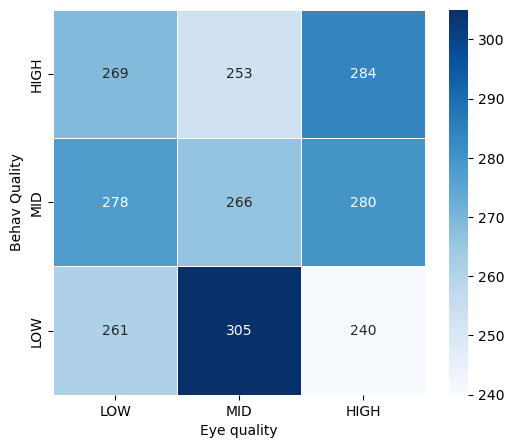

In [65]:
import seaborn as sns

categories = ['LOW', 'MID', 'HIGH', 'NA']

# Create a contingency table, ensuring the correct order
heatmap_data = pd.crosstab(
    trial_err_df['behav_tag'], 
    trial_err_df['eye_tag'])
heatmap_data = heatmap_data.reindex(
    index=categories, columns=categories, fill_value=0)
heatmap_data.drop('NA', axis=0, inplace=True)
heatmap_data.drop('NA', axis=1, inplace=True)

# Plot heatmap
fig, ax = plt.subplots(1, figsize=(6, 5))
sns.heatmap(
    heatmap_data, annot=True, ax=ax,
    cmap="Blues", fmt='d', linewidths=0.5)
ax.invert_yaxis()

# Labels
plt.xlabel("Eye quality")
plt.ylabel("Behav Quality")


### Trialwise correlation

This time only looks at those of a decent error (drop the long tail)

In [66]:
from scipy.stats import zscore
from scipy import stats

def percentile_performance(sub_df, col_name, max_err=40):
    src_col_name = f'{col_name}_err'
    target_col = f'{col_name}_normalized'
    abs_vals = sub_df[src_col_name].abs().to_numpy(copy=True)

    # filtering
    abs_vals[abs_vals > max_err] = np.nan

    zs = np.vectorize(lambda x: stats.percentileofscore(
        abs_vals, x, nan_policy='omit'))(abs_vals)
    
    zs = (50 - zs) / 50 # flip it
    
    sub_df[target_col] = zs

    return sub_df

# Apply categorization for each subject
trial_err_df = trial_err_df.groupby(
    'subject', group_keys=False).apply(
        percentile_performance, 'behav')
trial_err_df = trial_err_df.groupby(
    'subject', group_keys=False).apply(
        percentile_performance, 'eye')


/tmp/ipykernel_2772480/2192461046.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'subject', group_keys=False).apply(
/tmp/ipykernel_2772480/2192461046.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'subject', group_keys=False).apply(


#### Distribution of accuracy

(array([127., 115., 118., 112., 116., 121., 109., 121., 114., 116., 112.,
        122., 114., 116., 110., 123., 113., 116., 111., 127.]),
 array([-1.        , -0.90082645, -0.80165289, -0.70247934, -0.60330579,
        -0.50413223, -0.40495868, -0.30578512, -0.20661157, -0.10743802,
        -0.00826446,  0.09090909,  0.19008264,  0.2892562 ,  0.38842975,
         0.48760331,  0.58677686,  0.68595041,  0.78512397,  0.88429752,
         0.98347107]),
 <BarContainer object of 20 artists>)

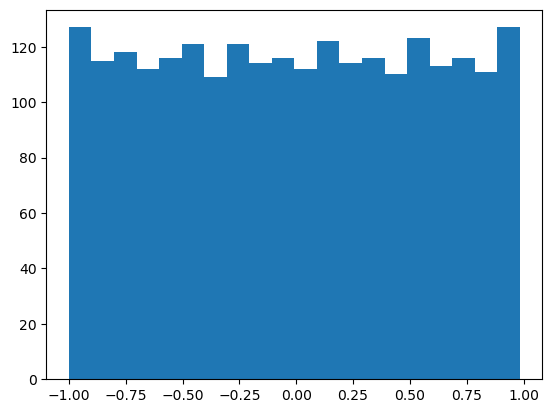

In [67]:
plt.hist(trial_err_df['behav_normalized'], bins=20)

[[-0.03904318  0.01840853]
 [ 0.00330293  0.102287  ]]
[0.48122937 0.03656495]


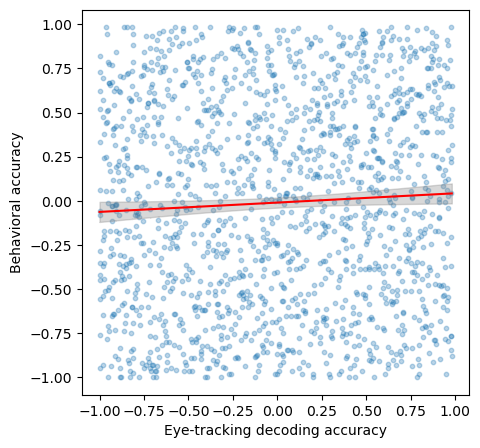

In [68]:
fig, ax = plt.subplots(1, figsize=(5, 5))
l1 = trial_err_df['eye_normalized'].to_numpy()
l2 = trial_err_df['behav_normalized'].to_numpy()

# only keep the middle part
mask = ~(np.isnan(l1) | np.isnan(l2))
l1 = l1[mask]
l2 = l2[mask]

ax.scatter(l1, l2, s=10, alpha=0.3)
ax.set_xlabel('Eye-tracking decoding accuracy')
ax.set_ylabel('Behavioral accuracy')
display_regression(ax, l1, l2)

In [69]:
# list of good subjects
good_subjects = [subj for subj in all_subjs 
    if eye_err_scale[subj]<35 and behav_err_scale[subj]<20]
good_subjects

[908, 909, 910, 912, 913, 914, 916, 921, 922, 927, 930, 931, 932, 937]

[[-0.03904318  0.01840853]
 [ 0.00330293  0.102287  ]]
[0.48122937 0.03656495]


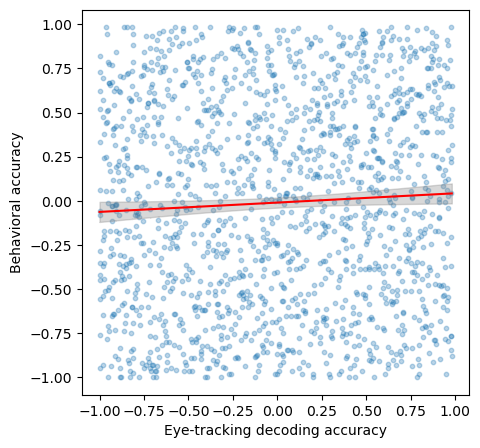

In [70]:
fig, ax = plt.subplots(1, figsize=(5, 5))

filtered_df = trial_err_df # trial_err_df[trial_err_df['subject'].isin(good_subjects)]
l1 = filtered_df['eye_normalized'].to_numpy()
l2 = filtered_df['behav_normalized'].to_numpy()

# only keep the middle part
mask = ~(np.isnan(l1) | np.isnan(l2))
l1 = l1[mask]
l2 = l2[mask]

ax.scatter(l1, l2, s=10, alpha=0.3)
ax.set_xlabel('Eye-tracking decoding accuracy')
ax.set_ylabel('Behavioral accuracy')
display_regression(ax, l1, l2)

Text(0, 0.5, 'Behavioral accuracy')

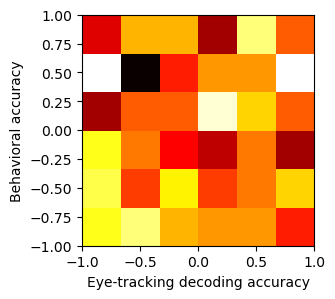

In [71]:
fig, ax = plt.subplots(1, figsize=(3, 3))
bins = np.linspace(-1, 1, 7)
l1 = filtered_df['eye_normalized'].to_numpy()
l2 = filtered_df['behav_normalized'].to_numpy()
H = np.histogram2d(l1, l2, bins=bins)[0]
ax.imshow(H.T, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='hot')
ax.set_xlabel('Eye-tracking decoding accuracy')
ax.set_ylabel('Behavioral accuracy')

Text(0, 0.5, '(Avg) Behavioral accuracy')

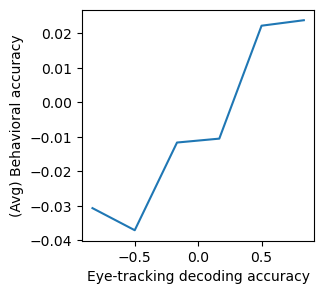

In [72]:
fig, ax = plt.subplots(1, figsize=(3, 3))
avg_bins = (bins[1:]+bins[:-1])*0.5
avg_behav_acc = np.sum(
    H*avg_bins, axis=1) / np.sum(H, axis=1)
ax.plot(avg_bins, avg_behav_acc)
ax.set_xlabel('Eye-tracking decoding accuracy')
ax.set_ylabel('(Avg) Behavioral accuracy')

Text(0, 0.5, '(Avg) eyetracking decoding accuracy')

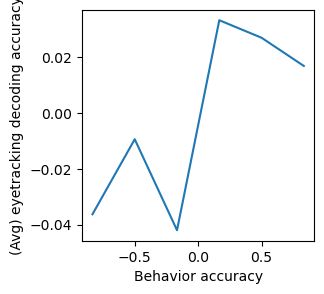

In [73]:
fig, ax = plt.subplots(1, figsize=(3, 3))
avg_bins = (bins[1:]+bins[:-1])*0.5
avg_eye_acc = np.sum(
    H.T*avg_bins, axis=1) / np.sum(H.T, axis=1)
ax.plot(avg_bins, avg_eye_acc)
ax.set_xlabel('Behavior accuracy')
ax.set_ylabel('(Avg) eyetracking decoding accuracy')